<a href="https://colab.research.google.com/github/Vijay14501/Cardiovascular-Risk-Prediction/blob/main/Cardiovascular_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cardiovascular Risk Prediction**

Project Type - Classification

Contribution - Individual

Team Member 1- Vijay N




**Project Summary**

Data Preprocessing :

1.Getting the dataset

2.Importing libraries

3.Importing datasets

4.Finding Missing Data

5.Encoding Categorical Data

6.Data Cleaning and Feature Engineering

**Exploratory data analysis(EDA)** :

EDA is a fundamental part of data analysis that helps in ensuring data quality, understanding the data, and generating insights. It serves as the basis for making informed decisions throughout the data analysis process



*   Chances of getting Coronary Heart Disease
*   What is the likelihood of developing Coronary Heart Disease (CHD) over a ten-year period for males and females, and how do the percentages compare between the two genders

*  What is the percentage of smokers and non-smokers who develop CHD (Coronary Heart Disease)






**Supervise Machine learning algorithms and implementation :**

1.Logistic regression

2.Random Forest Classifier

3.XG Boost Classifier

4.Suppot Vector Classifier(SVM)

 **GitHub Link -**https://github.com/Vijay14501/Cardiovascular-Risk-Prediction.git

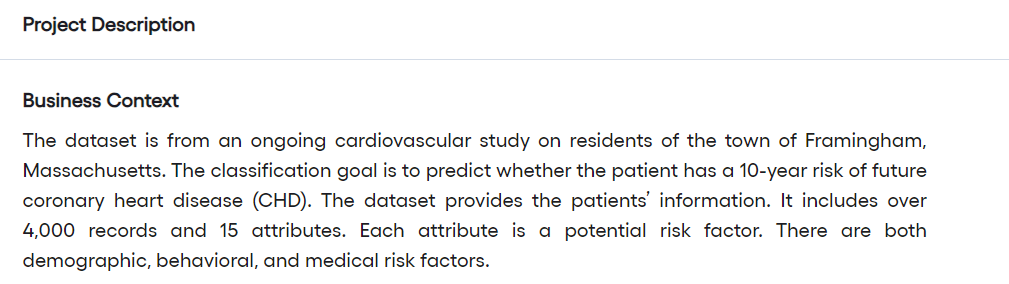

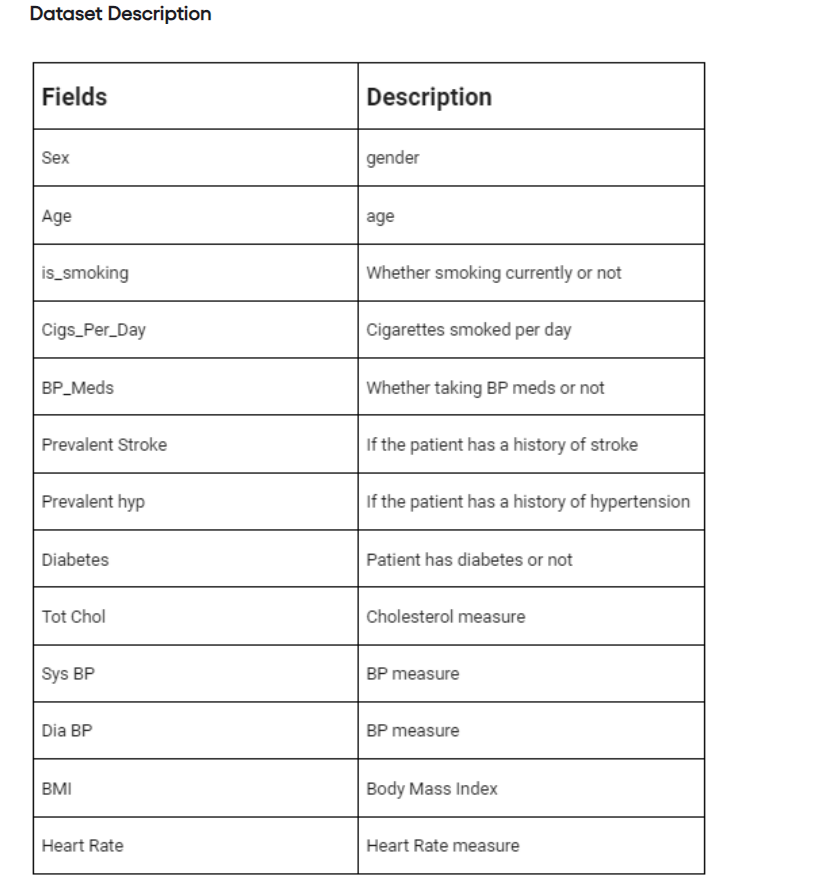

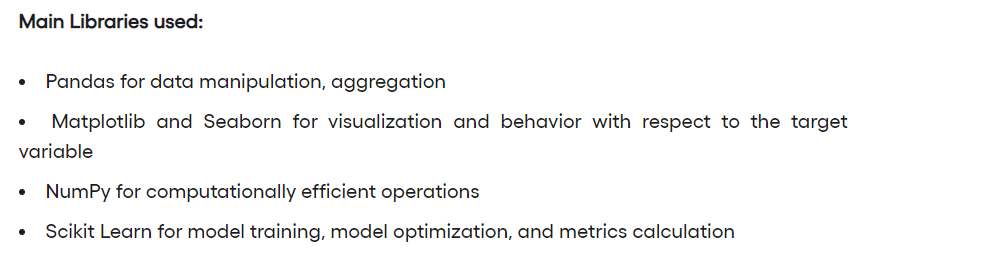

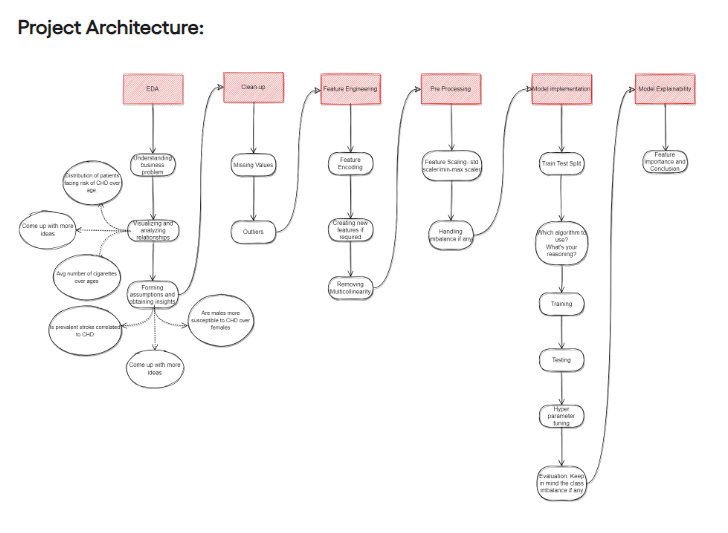

**Importing necessary libraries and reading the data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import make_scorer, recall_score, f1_score, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,roc_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import ensemble

from sklearn.svm import SVC

import xgboost as xgb

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/data set zomoto/data_cardiovascular_risk.csv')



**Define necessary functions**

In [4]:
def check_duplicates(dataset):
  '''This function will print if there are duplicates in the dataset'''

  if(len(dataset[dataset.duplicated()])>0):
    print("There are duplicates in the data. The number of Duplicates are ",len(dataset[dataset.duplicated()]))
  else:
    print("There are no duplicates")

In [5]:
def visualize_missing_percent(dataset):
  '''This function takes the dataframe as input as the input and gives the count of missing values,
  missing values in percentage per column and plots the same in a bargraph'''

  #total percentage of missing data
  if dataset.isnull().sum().sum()>0:
    print("Missing values found..Calculating the total...")
    missing_data = dataset.isnull().sum()
    total_percentage = (missing_data.sum()/dataset.shape[0]) * 100
    print(f'The total number of missing entries found is {dataset.isnull().sum().sum()}, that is {round(total_percentage,2)}%')
    print('')

    # percentage of missing data per category
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent_total = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)*100
    missing = pd.concat([total, percent_total], axis=1, keys=["Total", "Percentage"])
    missing_data = missing[missing['Total']>0]
    print(missing_data)
    print('')

    #Visualize the missing value percentage
    plt.figure(figsize=(9,6))
    sns.set(style="whitegrid")
    sns.barplot(x=missing_data.index, y=missing_data['Percentage'], data = missing_data)
    plt.title('Percentage of missing data by feature', fontsize=16)
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.show()
  else:
    print('Hurray! There are no missing values in the data.')


In [6]:
def visualize_cat_feature(column):
  '''This function takes the column of the dataframe as input
  and gives barplot of the categorical column as output'''

  dataset1 = dataset.groupby(['TenYearCHD',column]).agg('count').reset_index()
  dataset1 = dataset1.iloc[:,0:3]
  dataset1.rename(columns={'age':'count'},inplace=True)
  columns = dataset1.columns.values
  plt.figure(figsize=(7, 8))
  plt.title(f'Ten Year CHD vs {columns[1]}',fontsize=16)
  ax = sns.barplot(x = columns[1], y = "count" , hue="TenYearCHD", data=dataset1,palette='Spectral')

  for p in ax.patches:
      ax.annotate(str(p.get_height()), (p.get_x() , p.get_height() ))

  plt.show()

In [7]:
def get_iqr(column):
  '''This function is used to get the first and third quartile of the given colunm'''
  q1 = np.percentile(column, 25)
  q3 = np.percentile(column, 75)
  return q1,q3

In [8]:
def visualize_num_feature(df):
  '''This function is used to plot the distribution and box plot of a column. It takes column as a input'''

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  ax = sns.distplot(df)
  ax.axvline(df.mean(), color='blue', linestyle='dashed', linewidth=2)
  ax.axvline(df.median(), color='green', linestyle='dashed', linewidth=2)
  plt.title(f'Distribution of column {df.name}', fontsize=16)

  plt.subplot(1,2,2)
  sns.boxplot(df)

  plt.show()

In [9]:
def calc_vif(X):
  '''This function is used to check the collinearity between columns.
    It takes dataframe as the input and gives the variance inflaction factor for the induced by each column'''

  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  return(vif)

In [10]:
# Defining a function to train the input model and print evaluation matrix
def analyse_model(model, X_train, X_test, y_train, y_test):

  '''Takes classifier model and train test splits as input and prints the
  evaluation matrices with the plot and returns the model'''

  # Fitting the model
  model.fit(X_train,y_train)

  # Feature importances
  try:
    try:
      importance = model.feature_importances_
      feature = features
    except:
      importance = np.abs(model.coef_[0])
      feature = features
    indices = np.argsort(importance)
    indices = indices[::-1]
  except:
    pass

  # Plotting Evaluation Metrics for train and test dataset
  for x, act, label in ((X_train, y_train, 'Train-Set'),(X_test, y_test, "Test-Set")):

    # Getting required metrics
    pred = model.predict(x)
    pred_proba = model.predict_proba(x)[:,1]
    report = pd.DataFrame(classification_report(y_pred=pred, y_true=act, output_dict=True))
    fpr, tpr, thresholds = roc_curve(act, pred_proba)

    # Classification report
    plt.figure(figsize=(18,3))
    plt.subplot(1,3,1)
    sns.heatmap(report.iloc[:-1, :-1].T, annot=True, cmap='Blues')
    plt.title(f'{label} Report')

    # Confusion Matrix
    plt.subplot(1,3,2)
    sns.heatmap(confusion_matrix(y_true=act, y_pred=pred), annot=True, cmap='Blues')
    plt.title(f'{label} Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('Actual labels')

    # AUC_ROC Curve
    plt.subplot(1,3,3)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr,tpr,label=f'AUC = {np.round(np.trapz(tpr,fpr),3)}')
    plt.legend(loc=4)
    plt.title(f'{label} AUC_ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.tight_layout()

  # Plotting Feature Importance
  try:
    plt.figure(figsize=(18,4))
    plt.bar(range(len(indices)),importance[indices], color='lightsteelblue')
    plt.xticks(range(len(indices)), [feature[i] for i in indices])
    plt.title('Feature Importance')
    plt.tight_layout()
  except:
    pass
  plt.show()

  return model

**Data Inspection**

In [11]:
print("The shape of the dataset is ",dataset.shape)

The shape of the dataset is  (3390, 17)


In [12]:
original_rows = dataset.shape[0]

In [13]:
#Familiarize with the dataset columns
dataset.head(5)


id  age  education sex is_smoking  cigsPerDay  BPMeds  prevalentStroke  \
0   0   64        2.0   F        YES         3.0     0.0                0   
1   1   36        4.0   M         NO         0.0     0.0                0   
2   2   46        1.0   F        YES        10.0     0.0                0   
3   3   50        1.0   M        YES        20.0     0.0                0   
4   4   64        1.0   F        YES        30.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    221.0  148.0   85.0    NaN       90.0     80.0   
1             1         0    212.0  168.0   98.0  29.77       72.0     75.0   
2             0         0    250.0  116.0   71.0  20.35       88.0     94.0   
3             1         0    233.0  158.0   88.0  28.26       68.0     94.0   
4             0         0    241.0  136.5   85.0  26.42       70.0     77.0   

   TenYearCHD  
0           1  
1           0  
2           0  
3           1  
4           0

In [14]:
#Familiarize with the dataset columns
dataset.tail(5)

id  age  education sex is_smoking  cigsPerDay  BPMeds  \
3385  3385   60        1.0   F         NO         0.0     0.0   
3386  3386   46        1.0   F         NO         0.0     0.0   
3387  3387   44        3.0   M        YES         3.0     0.0   
3388  3388   60        1.0   M         NO         0.0     NaN   
3389  3389   54        3.0   F         NO         0.0     0.0   

      prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
3385                0             0         0    261.0  123.5   79.0  29.28   
3386                0             0         0    199.0  102.0   56.0  21.96   
3387                0             1         0    352.0  164.0  119.0  28.92   
3388                0             1         0    191.0  167.0  105.0  23.01   
3389                0             0         0    288.0  124.0   77.0  29.88   

      heartRate  glucose  TenYearCHD  
3385       70.0    103.0           0  
3386       80.0     84.0           0  
3387       73.0     72.0           1  
3388       80.0     85.0           0  
3389       79.0     92.0           0

In [15]:
print("Lets take a look at the statistics of the columns")
dataset.describe(include='all')

Lets take a look at the statistics of the columns


id          age    education   sex is_smoking   cigsPerDay  \
count   3390.000000  3390.000000  3303.000000  3390       3390  3368.000000   
unique          NaN          NaN          NaN     2          2          NaN   
top             NaN          NaN          NaN     F         NO          NaN   
freq            NaN          NaN          NaN  1923       1703          NaN   
mean    1694.500000    49.542183     1.970936   NaN        NaN     9.069477   
std      978.753033     8.592878     1.019081   NaN        NaN    11.879078   
min        0.000000    32.000000     1.000000   NaN        NaN     0.000000   
25%      847.250000    42.000000     1.000000   NaN        NaN     0.000000   
50%     1694.500000    49.000000     2.000000   NaN        NaN     0.000000   
75%     2541.750000    56.000000     3.000000   NaN        NaN    20.000000   
max     3389.000000    70.000000     4.000000   NaN        NaN    70.000000   

             BPMeds  prevalentStroke  prevalentHyp     diabetes      totChol  \
count   3346.000000      3390.000000   3390.000000  3390.000000  3352.000000   
unique          NaN              NaN           NaN          NaN          NaN   
top             NaN              NaN           NaN          NaN          NaN   
freq            NaN              NaN           NaN          NaN          NaN   
mean       0.029886         0.006490      0.315339     0.025664   237.074284   
std        0.170299         0.080309      0.464719     0.158153    45.247430   
min        0.000000         0.000000      0.000000     0.000000   107.000000   
25%        0.000000         0.000000      0.000000     0.000000   206.000000   
50%        0.000000         0.000000      0.000000     0.000000   234.000000   
75%        0.000000         0.000000      1.000000     0.000000   264.000000   
max        1.000000         1.000000      1.000000     1.000000   696.000000   

             sysBP        diaBP          BMI    heartRate      glucose  \
count   3390.00000  3390.000000  3376.000000  3389.000000  3086.000000   
unique         NaN          NaN          NaN          NaN          NaN   
top            NaN          NaN          NaN          NaN          NaN   
freq           NaN          NaN          NaN          NaN          NaN   
mean     132.60118    82.883038    25.794964    75.977279    82.086520   
std       22.29203    12.023581     4.115449    11.971868    24.244753   
min       83.50000    48.000000    15.960000    45.000000    40.000000   
25%      117.00000    74.500000    23.020000    68.000000    71.000000   
50%      128.50000    82.000000    25.380000    75.000000    78.000000   
75%      144.00000    90.000000    28.040000    83.000000    87.000000   
max      295.00000   142.500000    56.800000   143.000000   394.000000   

         TenYearCHD  
count   3390.000000  
unique          NaN  
top             NaN  
freq            NaN  
mean       0.150737  
std        0.357846  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [16]:
#Checking the datatype of columns
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

**Data Exploration**

**Checking for duplicates**

Eliminating duplicate records from your data is essential because it signifies the presence of redundant information. These duplicates may arise from a variety of sources, including data input mistakes or the way data is gathered. By eradicating such redundancies, you can achieve significant time and cost savings, especially in scenarios where communications or actions are based on the data. Removing duplicates ensures that the same information is not relayed multiple times to the same individuals, thereby optimizing efficiency and resource allocation.

In [17]:
#Checking for duplicates
check_duplicates(dataset)


There are no duplicates


**Null/Missing Values and Outlier Treatment**

Dealing with missing values is a crucial step in data preprocessing. In practical datasets, missing values are a common occurrence and can arise due to various reasons, such as data corruption, incomplete records, or human error in data collection. It is imperative to address missing data because numerous machine learning algorithms are not equipped to handle datasets containing gaps or null values. Therefore, it's essential to prioritize the identification and handling of missing values as one of the initial steps in data analysis and preprocessing.

"The 'ID' column serves as a row identifier and does not provide any meaningful contribution to our analysis. Therefore, we have decided to exclude it from our dataset. At this point, we will compile a list of all the columns that are irrelevant to our analysis and proceed to drop them from the dataset

In [18]:
dataset.drop('id',axis=1,inplace=True)

Missing values found..Calculating the total...
The total number of missing entries found is 510, that is 15.04%

            Total  Percentage
glucose       304    8.967552
education      87    2.566372
BPMeds         44    1.297935
totChol        38    1.120944
cigsPerDay     22    0.648968
BMI            14    0.412979
heartRate       1    0.029499



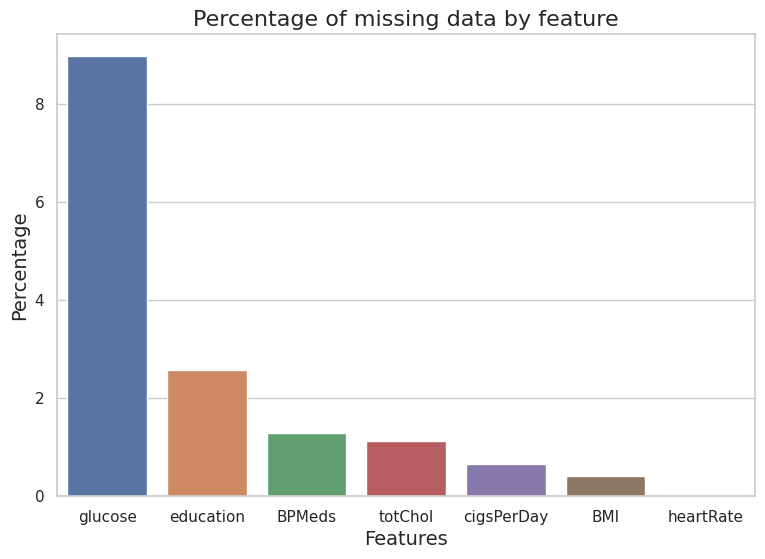

In [19]:
visualize_missing_percent(dataset)

The 'glucose' column stands out with the highest proportion of missing data, accounting for 8.9% of the total missing values. In contrast, the remaining features exhibit relatively minimal occurrences of missing entries.

Since the educational qualification of individuals does not have any discernible influence on their likelihood of developing a heart disease in the future, we have decided to remove this particular column from our dataset

In [20]:
dataset.drop('education',axis=1,inplace=True)

After dropping of education columns, again checking for null values

Missing values found..Calculating the total...
The total number of missing entries found is 423, that is 12.48%

            Total  Percentage
glucose       304    8.967552
BPMeds         44    1.297935
totChol        38    1.120944
cigsPerDay     22    0.648968
BMI            14    0.412979
heartRate       1    0.029499



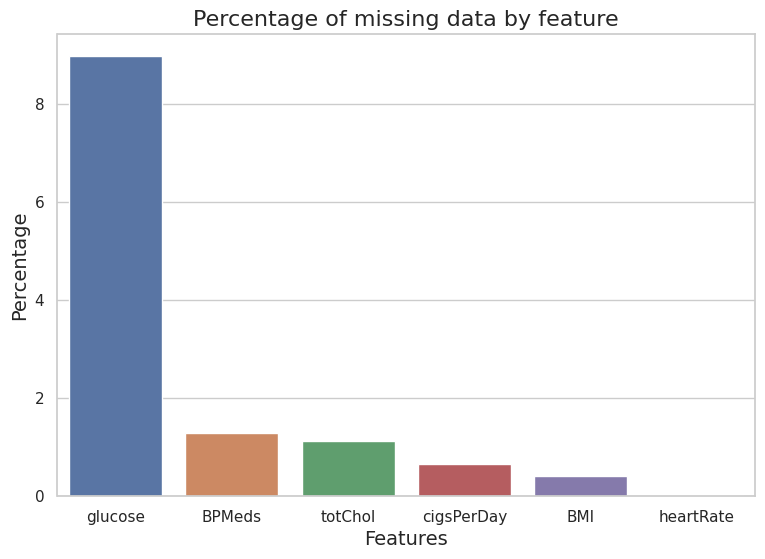

In [21]:
visualize_missing_percent(dataset)

Glucose

In [22]:
dataset.glucose.name

'glucose'

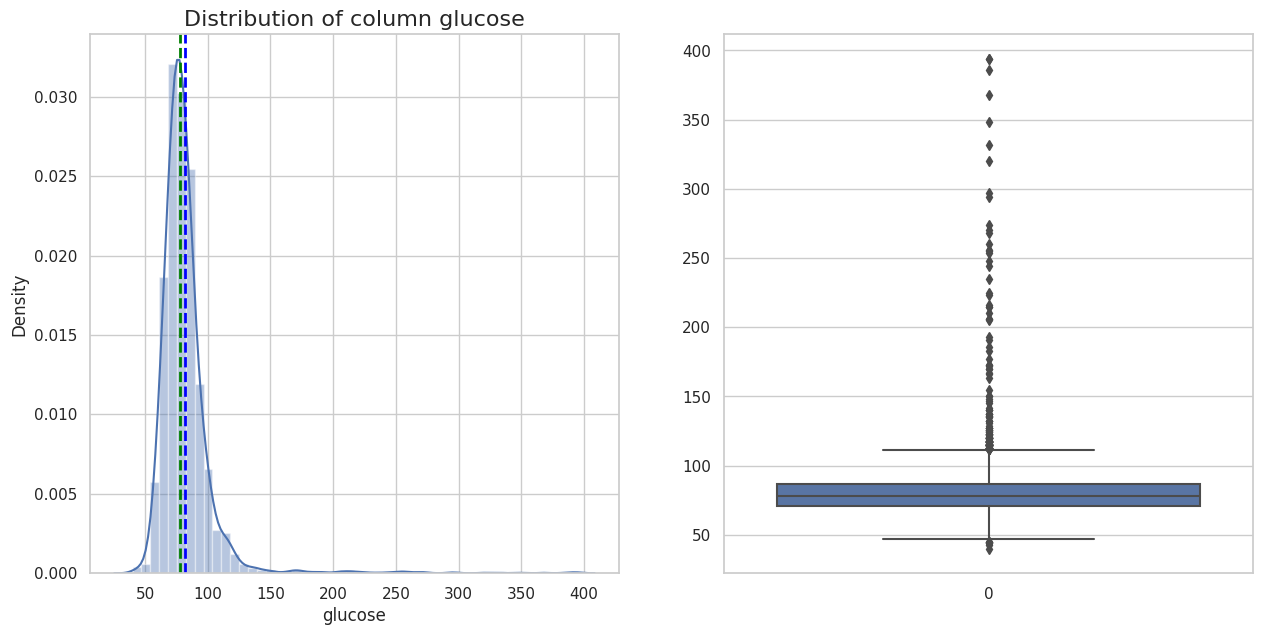

In [23]:
visualize_num_feature(dataset.glucose)

In [24]:
#Checking for mean and median on the basis of the presence of diabetes
print(dataset.groupby('diabetes')['glucose'].mean())
print(dataset.groupby('diabetes')['glucose'].median())

diabetes
0     79.571619
1    171.964286
Name: glucose, dtype: float64
diabetes
0     78.0
1    150.0
Name: glucose, dtype: float64


We adopt a thoughtful strategy for handling missing glucose values by replacing them with the median glucose value specific to individuals with or without diabetes. This approach takes into account the inherent differences in glucose levels, as individuals with diabetes typically exhibit higher glucose levels compared to those without the condition. Instead of a blanket replacement with the overall median, our method offers a more contextually meaningful imputation

In [25]:
dataset.loc[(dataset['diabetes']==1) & (dataset['glucose'].isnull()),'glucose'] = dataset.groupby('diabetes')['glucose'].median()[1]
dataset.loc[(dataset['diabetes']==0) & (dataset['glucose'].isnull()),'glucose'] = dataset.groupby('diabetes')['glucose'].median()[0]

Treating outliers

In [26]:
#getting first and third inter quartile values for the column
first, third = get_iqr(dataset.glucose)

In [27]:
#Replacing outliers
dataset.loc[dataset['glucose']>(third + 1.5 * (third-first)),'glucose'] = (third + 1.5 * (third-first))
dataset.loc[dataset['glucose']<(first - 1.5 * (third-first)),'glucose'] = (first - 1.5 * (third-first))

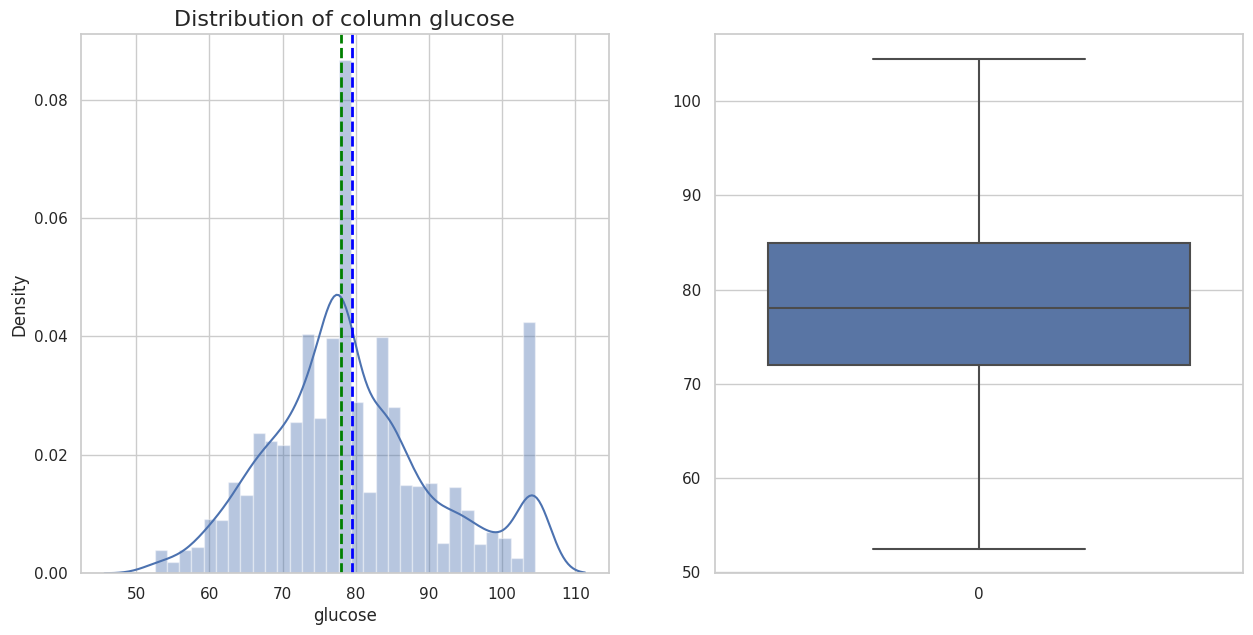

In [28]:
visualize_num_feature(dataset.glucose)

BPMeds

In [29]:
dataset['BPMeds'].value_counts()

0.0    3246
1.0     100
Name: BPMeds, dtype: int64

We are replacing the 'BPMeds' variable with a value of 1 if 'prevalentHyp' is also 1, and vice versa. This replacement is made under the assumption that if an individual is diagnosed with hypertension ('prevalentHyp' is 1), they are likely to be under medication ('BPMeds' is 1) in a manner consistent with common real-life scenarios.

In [30]:
dataset.loc[(dataset['prevalentHyp']==1) & (dataset['BPMeds'].isnull()),'BPMeds'] = 1
dataset.loc[(dataset['prevalentHyp']==0) & (dataset['BPMeds'].isnull()),'BPMeds'] = 0

In [31]:
dataset['BPMeds'].value_counts()

0.0    3271
1.0     119
Name: BPMeds, dtype: int64

Cigaratte per day

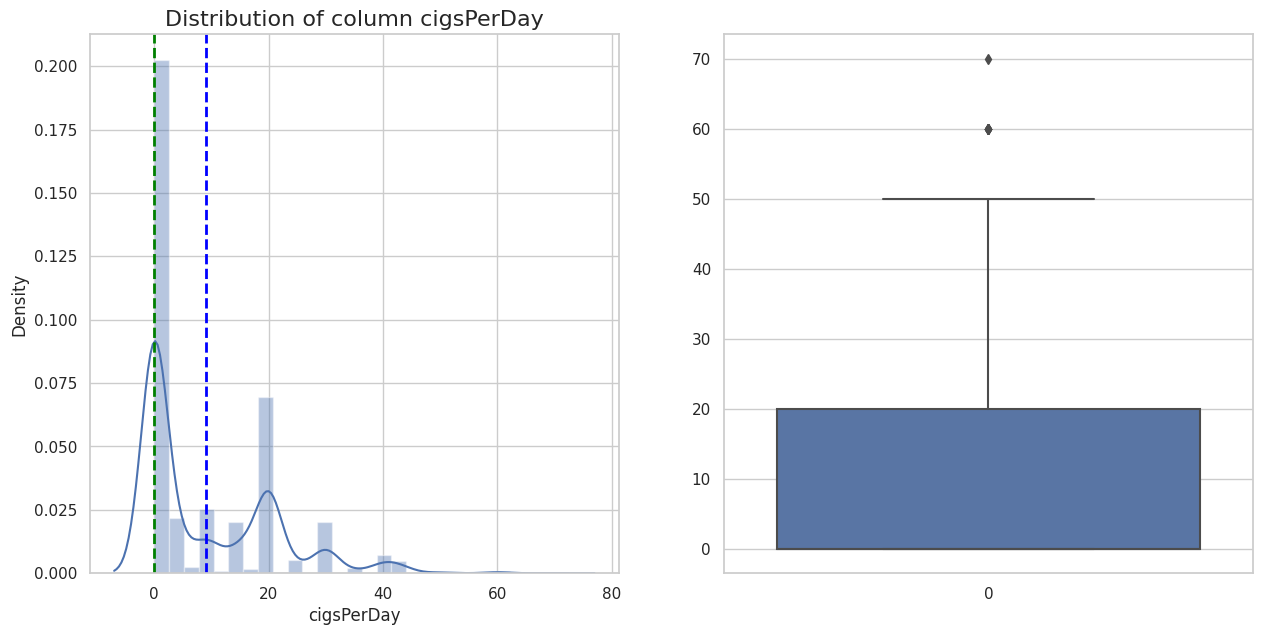

In [32]:
visualize_num_feature(dataset.cigsPerDay)

In [33]:
# Replacing null values in cigsPerDay with the mean value of the column
dataset.loc[dataset['cigsPerDay'].isnull(),'cigsPerDay']=np.floor(dataset['cigsPerDay'].mean())

In [34]:
print(f'The number of outliers present in the column is ',len(dataset[dataset['cigsPerDay']>=50]))

The number of outliers present in the column is  15


Treating outliers

In [35]:
first, third = get_iqr(dataset.cigsPerDay)

In [36]:
#Replacing the outliers with third quartile range
dataset.loc[dataset['cigsPerDay']>(third + 1.5 * (third-first)),'cigsPerDay'] = (third + 1.5 * (third-first))

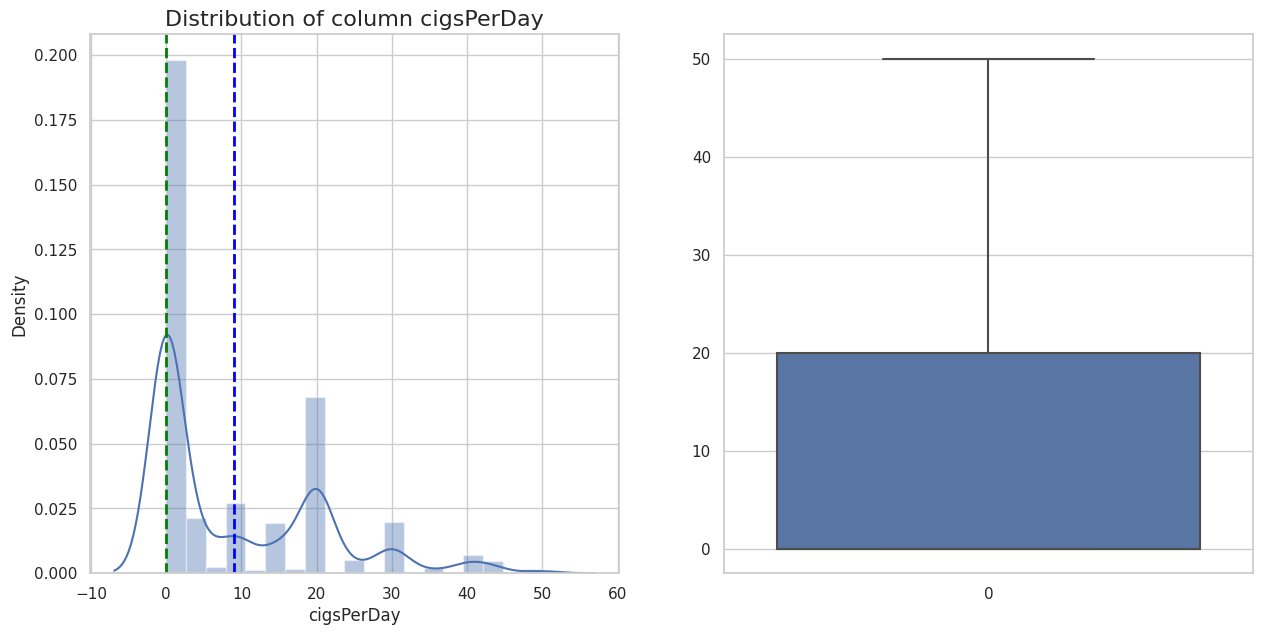

In [37]:
visualize_num_feature(dataset.cigsPerDay)

Total cholesterol

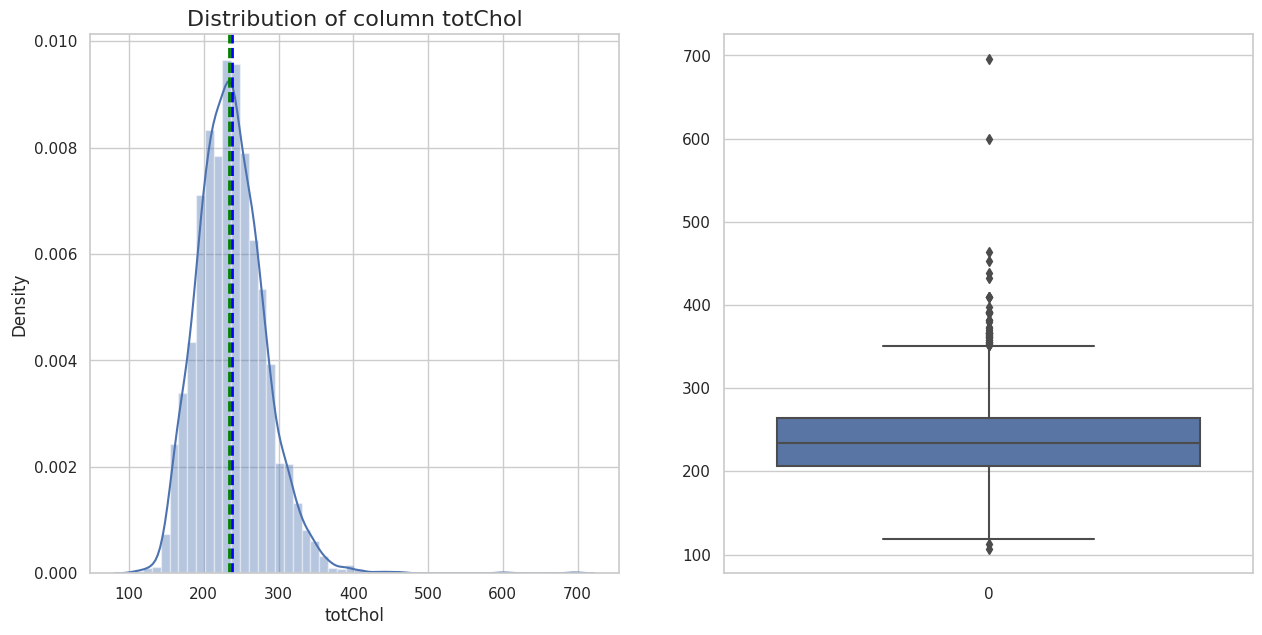

In [38]:
visualize_num_feature(dataset.totChol)

In [39]:
#Replacing null values in total cholesterol column with median as the distribution is close to normal
dataset.loc[dataset['totChol'].isnull(),'totChol']=dataset['totChol'].median()

Treating outliers

In [40]:
first, third = get_iqr(dataset.totChol)

In [41]:
dataset.loc[dataset['totChol']>(third + 1.5 * (third-first)),'totChol'] = (third + 1.5 * (third-first))
dataset.loc[dataset['totChol']<(first - 1.5 * (third-first)),'totChol'] = (first - 1.5 * (third-first))

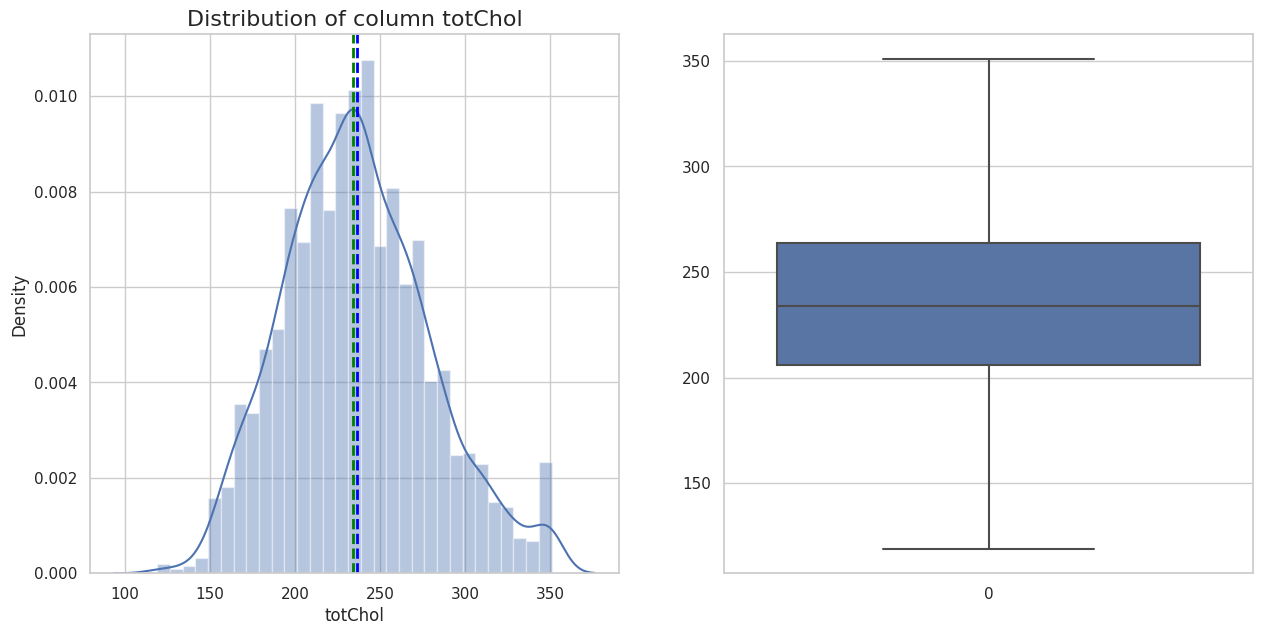

In [42]:
visualize_num_feature(dataset.totChol)

BMI

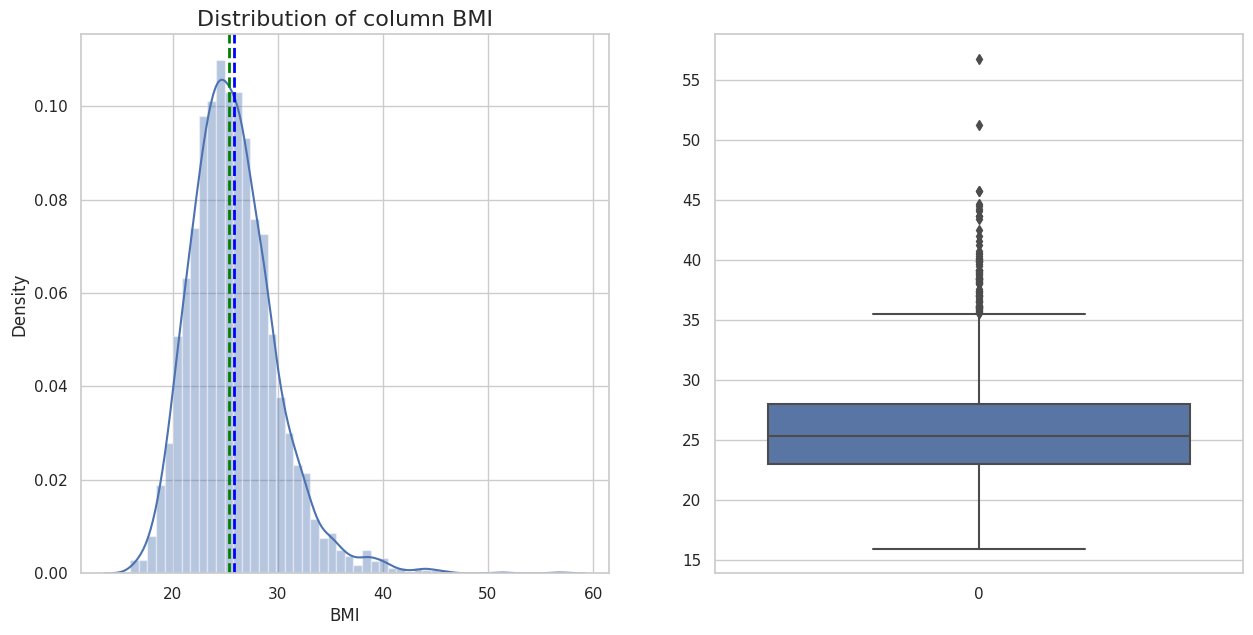

In [43]:
visualize_num_feature(dataset.BMI)

Since the distribution is close to normal, we are replacing the missing values with median

In [44]:
dataset.loc[dataset['BMI'].isnull(),'BMI']=dataset['BMI'].median()

Treating outliers

In [45]:
first, third = get_iqr(dataset.BMI)

In [46]:
dataset.loc[dataset['BMI']>(third + 1.5 * (third-first)),'BMI'] = (third + 1.5 * (third-first))
dataset.loc[dataset['BMI']<(first - 1.5 * (third-first)),'BMI'] = (first - 1.5 * (third-first))

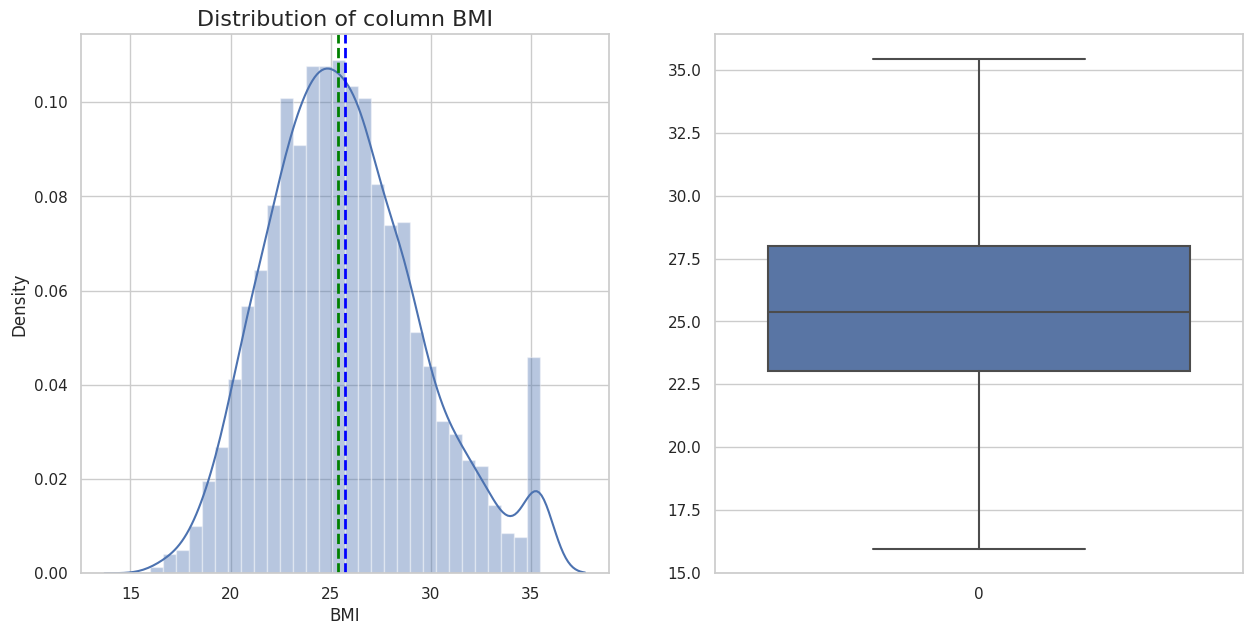

In [47]:
visualize_num_feature(dataset.BMI)

Heart rate

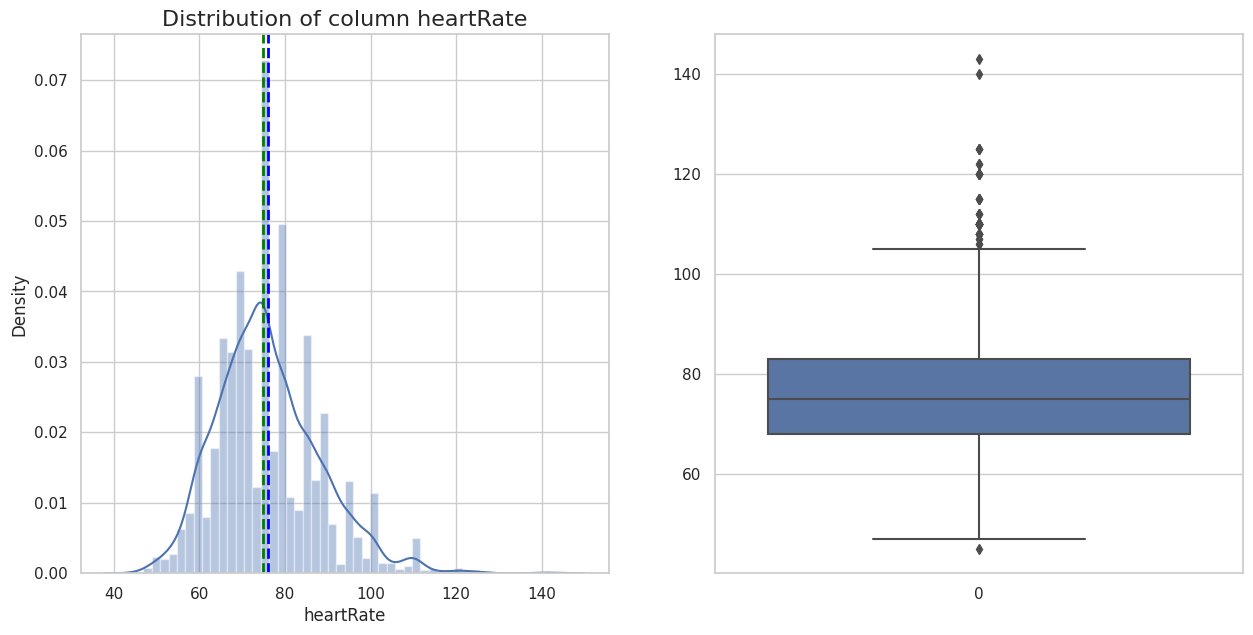

In [48]:
visualize_num_feature(dataset.heartRate)

In [49]:
dataset.loc[dataset['heartRate'].isnull(),'heartRate']=dataset['heartRate'].median()

Treating outliers

In [50]:
first, third = get_iqr(dataset.heartRate)

In [51]:
dataset.loc[dataset['heartRate']>(third + 1.5 * (third-first)),'heartRate'] = (third + 1.5 * (third-first))
dataset.loc[dataset['heartRate']<(first - 1.5 * (third-first)),'heartRate'] = (first - 1.5 * (third-first))

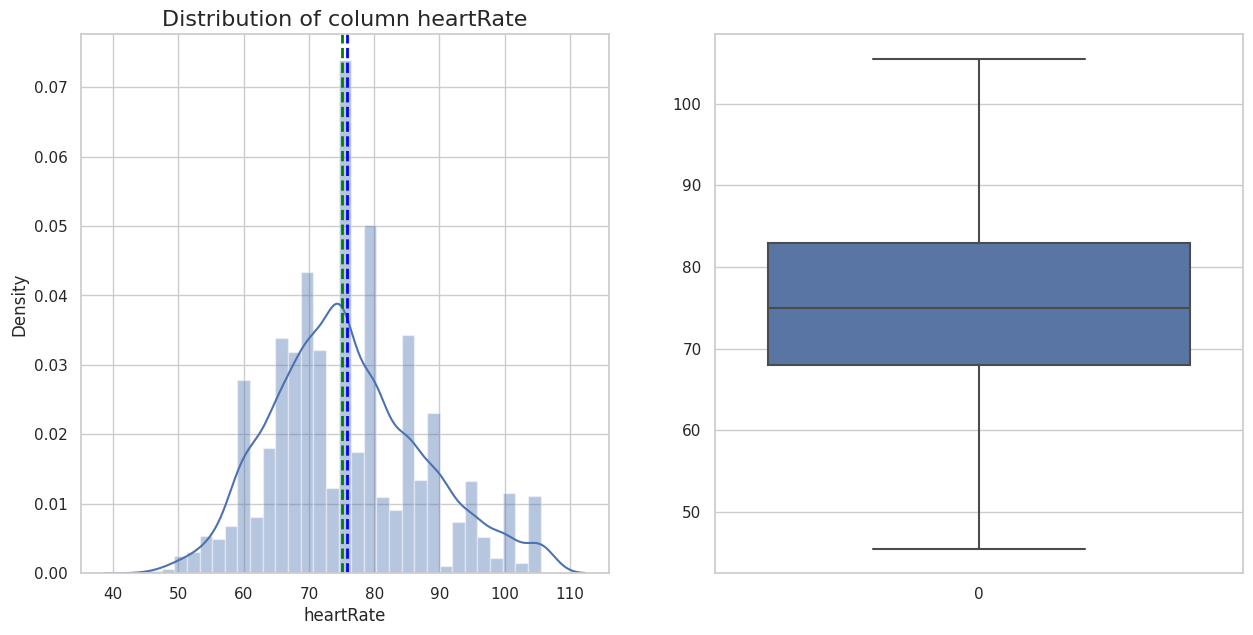

In [52]:
visualize_num_feature(dataset.heartRate)

SysBP

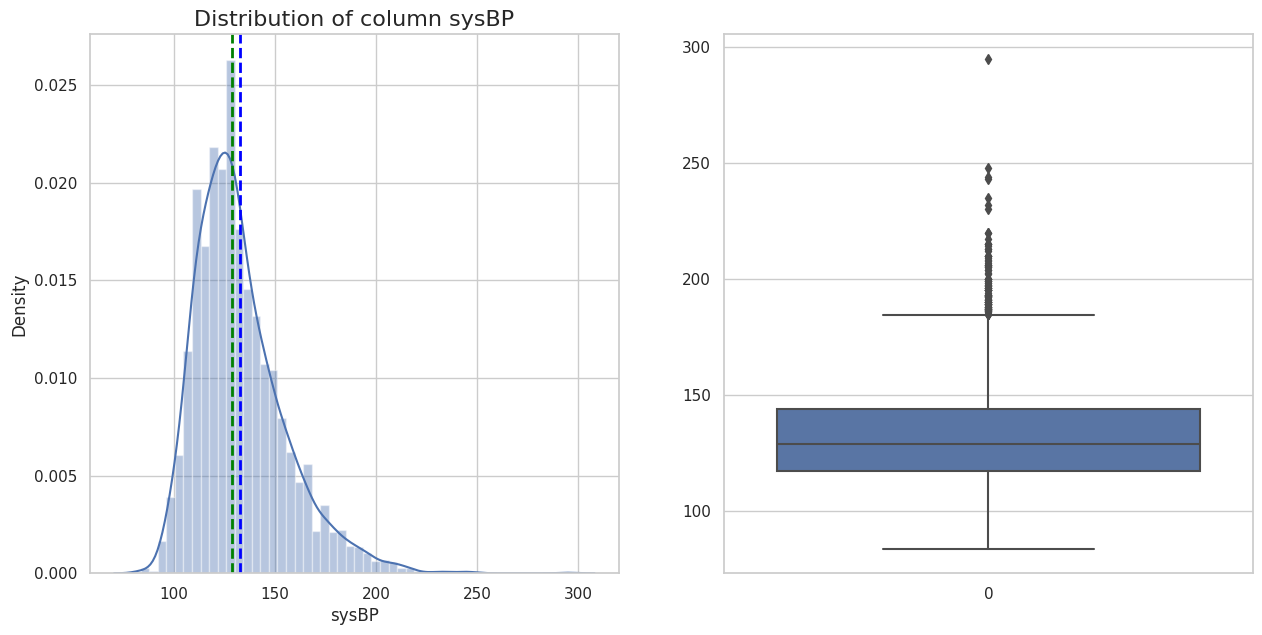

In [53]:
visualize_num_feature(dataset.sysBP)

Treating outliers

In [54]:
first, third = get_iqr(dataset.sysBP)

In [55]:
third + 1.5 * (third-first)

184.5

In [56]:
dataset.loc[dataset['sysBP']>(third + 1.5 * (third-first)),'sysBP'] = (third + 1.5 * (third-first))

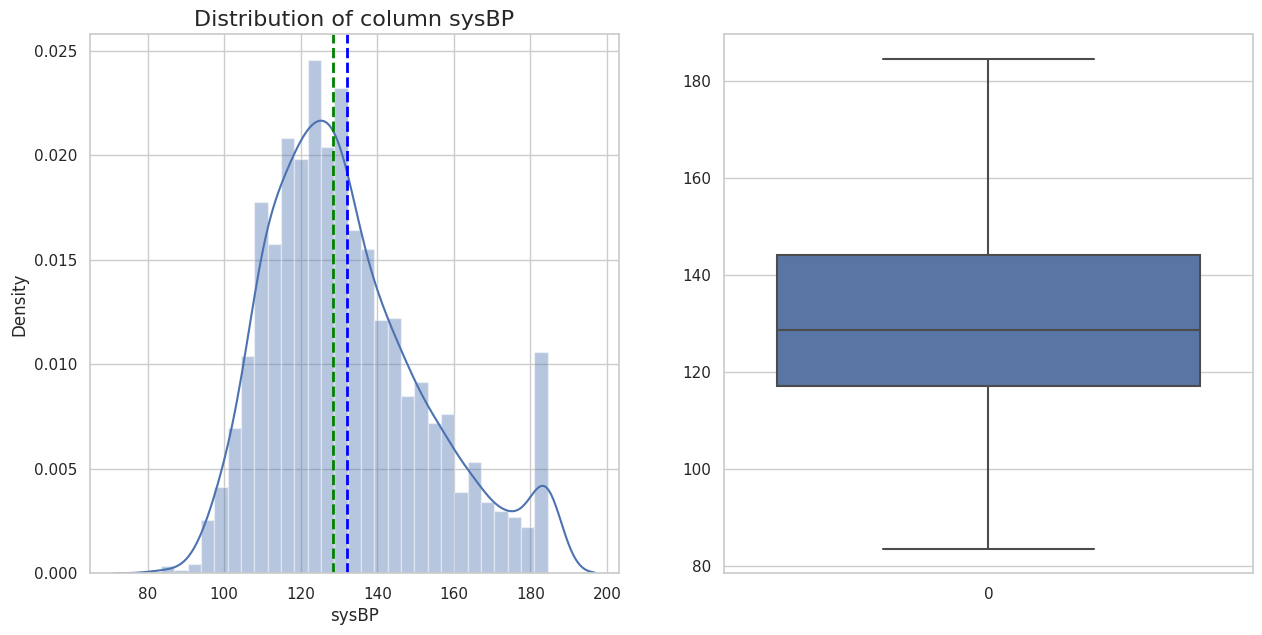

In [57]:
visualize_num_feature(dataset.sysBP)

Dia BP

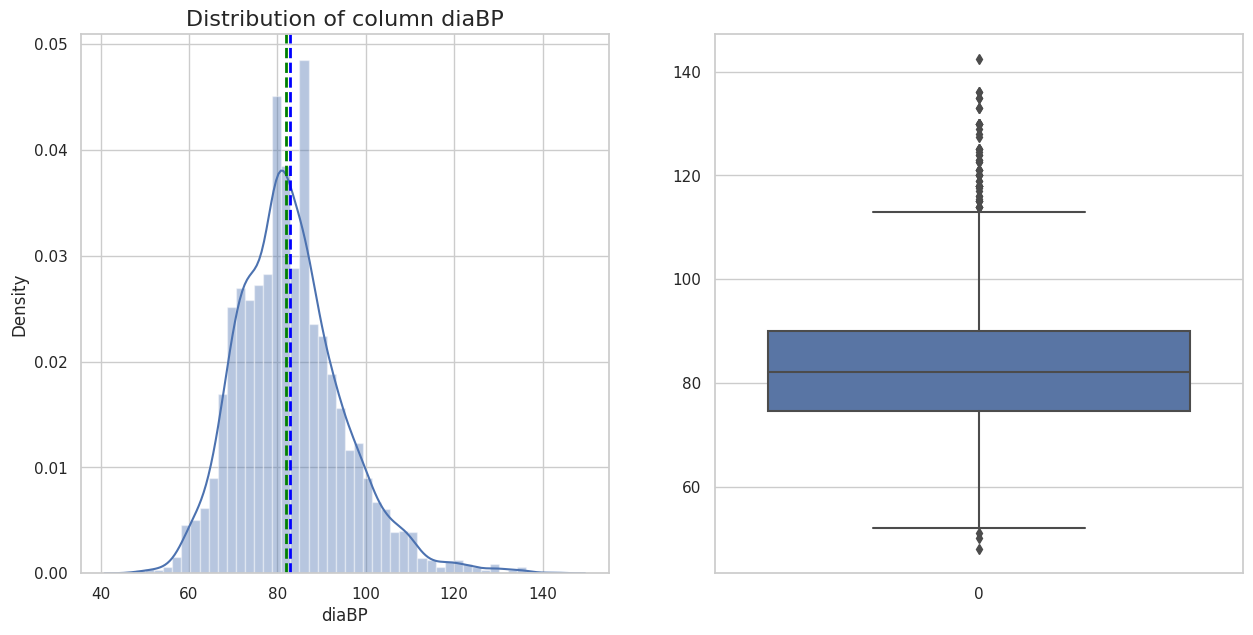

In [58]:
visualize_num_feature(dataset.diaBP)

In [59]:
first, third = get_iqr(dataset.diaBP)

In [60]:
dataset.loc[dataset['diaBP']>(third + 1.5 * (third-first)),'diaBP'] = (third + 1.5 * (third-first))
dataset.loc[dataset['diaBP']<(first - 1.5 * (third-first)),'diaBP'] = (third + 1.5 * (third-first))

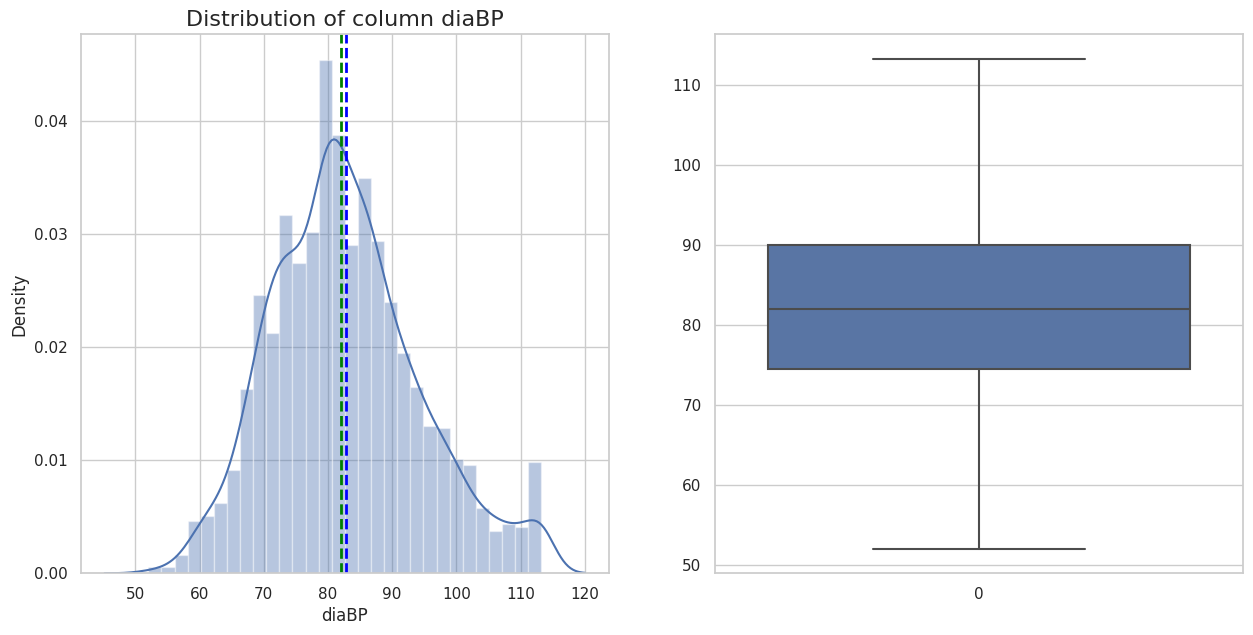

In [61]:
visualize_num_feature(dataset.diaBP)

**Exploratory Data Analysis Of The Data Set**

EDA is a fundamental part of data analysis that helps in ensuring data quality, understanding the data, and generating insights. It serves as the basis for making informed decisions throughout the data analysis process

**Chances of getting Coronary Heart Disease**

In [62]:
print("The minimun age present in the dataset is "+str(dataset['age'].min()))
print("The minimun age present in the dataset is "+str(dataset['age'].max()))

The minimun age present in the dataset is 32
The minimun age present in the dataset is 70


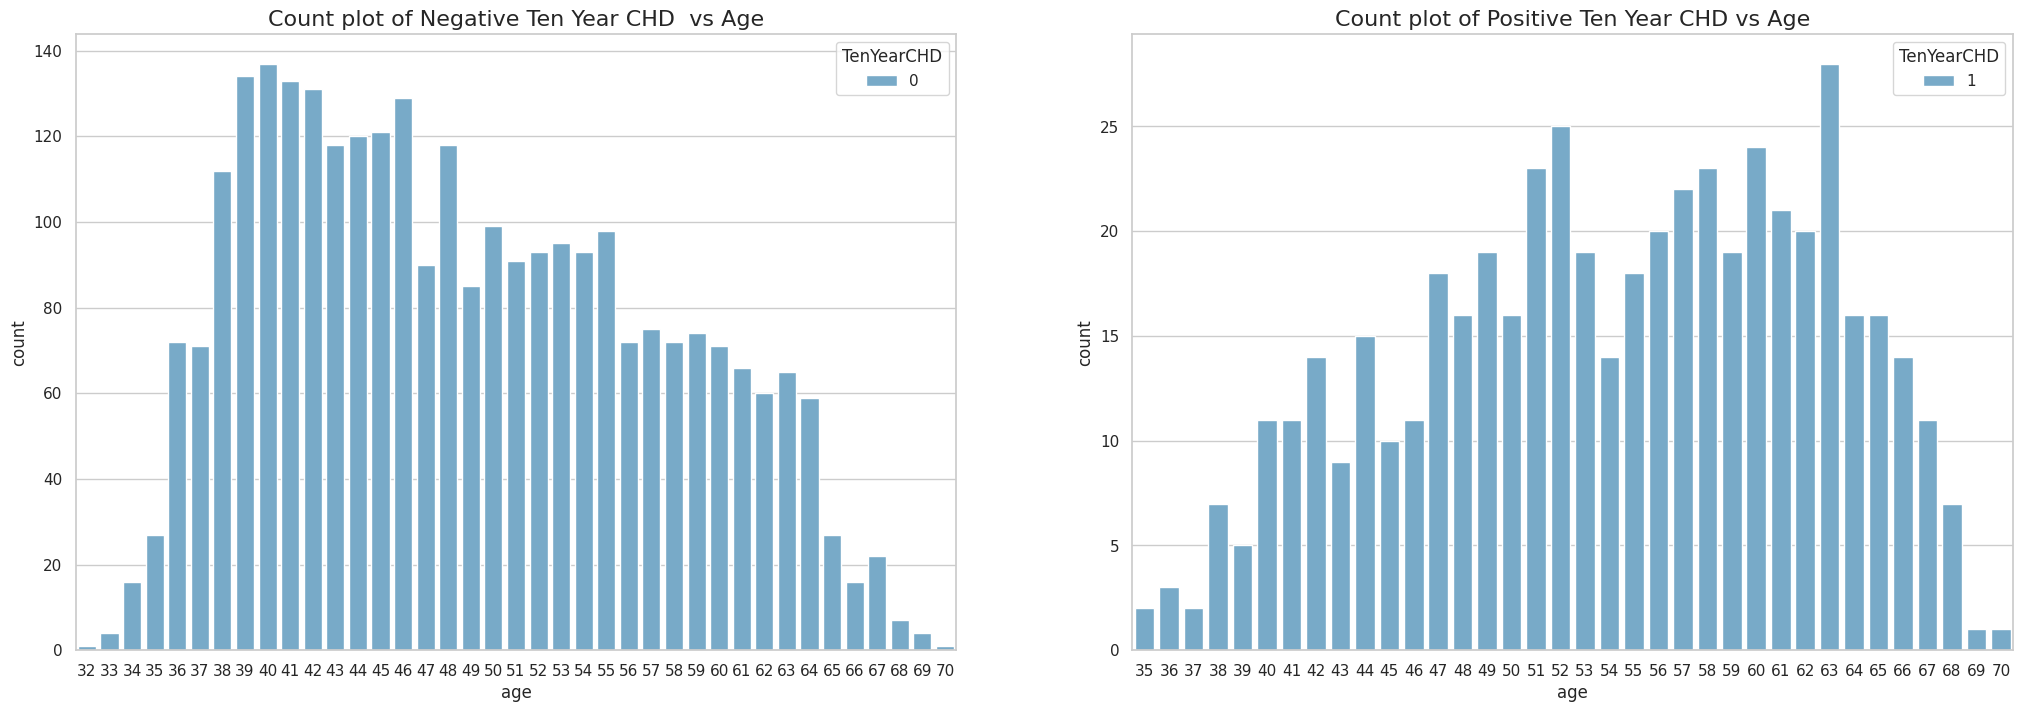

In [63]:
positive_cases = dataset[dataset['TenYearCHD'] == 0]
plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
sns.countplot(x='age',data = positive_cases, hue = 'TenYearCHD', palette='Blues')
plt.title("Count plot of Negative Ten Year CHD  vs Age", fontsize=16)

negative_cases = dataset[dataset['TenYearCHD'] == 1]
plt.subplot(1,2,2)
sns.countplot(x='age',data = negative_cases, hue = 'TenYearCHD', palette='Blues')
plt.title("Count plot of Positive Ten Year CHD vs Age", fontsize=16)

plt.show()


The chances of Getting Coronary Heart Disease is less for the lower age groups

**What is the likelihood of developing Coronary Heart Disease (CHD) over a ten-year period for males and females, and how do the percentages compare between the two genders**

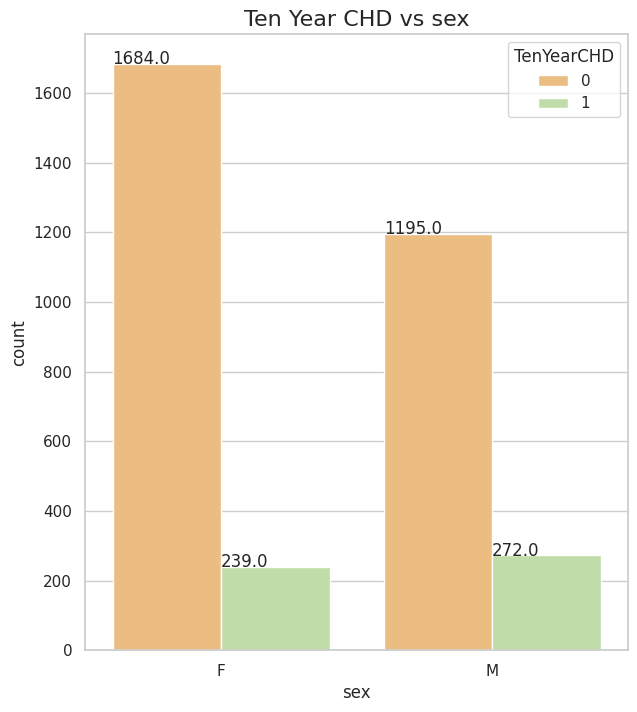

In [64]:
visualize_cat_feature(dataset.sex)


The likelihood of developing Coronary Heart Disease (CHD) over a ten-year period is higher in males, with 18.5% of males having this risk, compared to 12.4% of females

**What is the percentage of smokers and non-smokers who develop CHD (Coronary Heart Disease)**





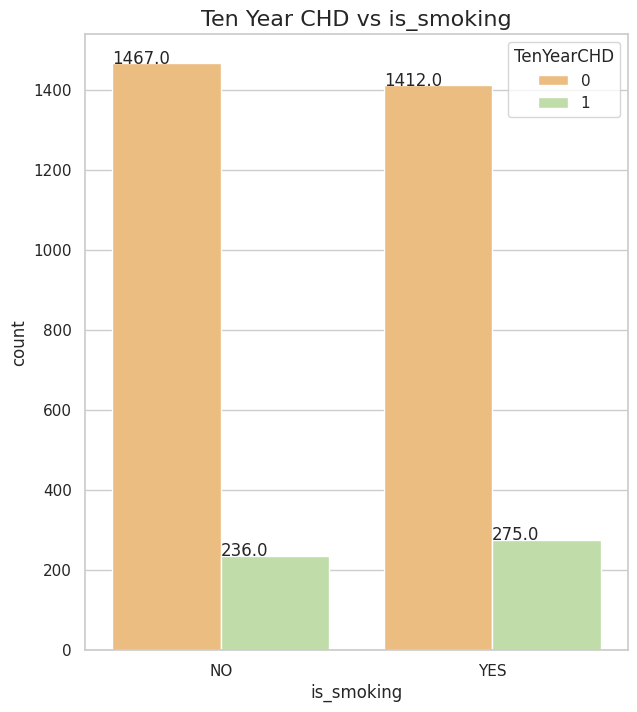

In [65]:
visualize_cat_feature(dataset.is_smoking)

13.8% of non smokers get CHD.

16.3% of smokers get CHD.

In [66]:
new_rows = dataset.shape[0]

In [67]:
print(round((new_rows/original_rows)*100,2),"% of data is retained after cleaning and analysis")

100.0 % of data is retained after cleaning and analysis


Since the dataset is small, we will be utilizing 100% of data without loosing any.

**Dependent Variable (TenYearCHD) analysis**





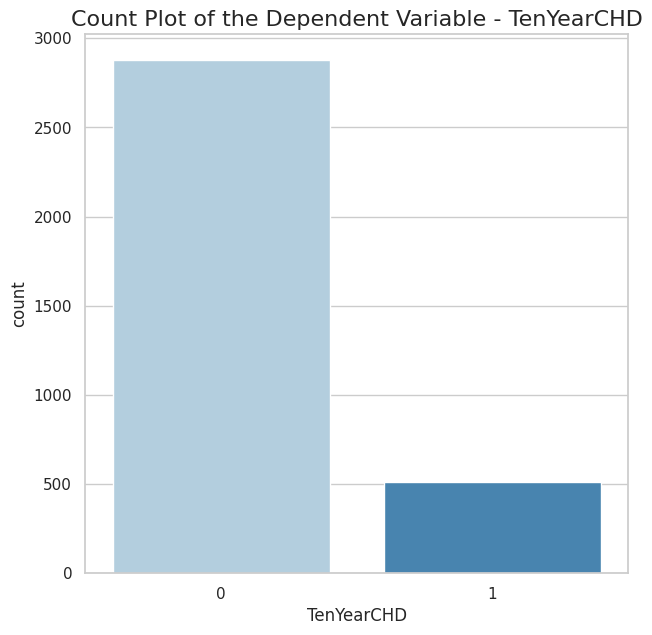

In [68]:
plt.figure(figsize=(7,7))
sns.countplot(x=dataset['TenYearCHD'],palette='Blues')
plt.title("Count Plot of the Dependent Variable - TenYearCHD",fontsize=16)
plt.show()

The dependent variable exhibits a significant class imbalance, with a notable disparity in the count between the two classes, representing ones and zeros.

**Univariate analysis**

Univariate analysis is a statistical and data analysis technique that involves the examination and interpretation of a single variable in isolation. In other words, it focuses on understanding the characteristics and distribution of a single variable within a dataset

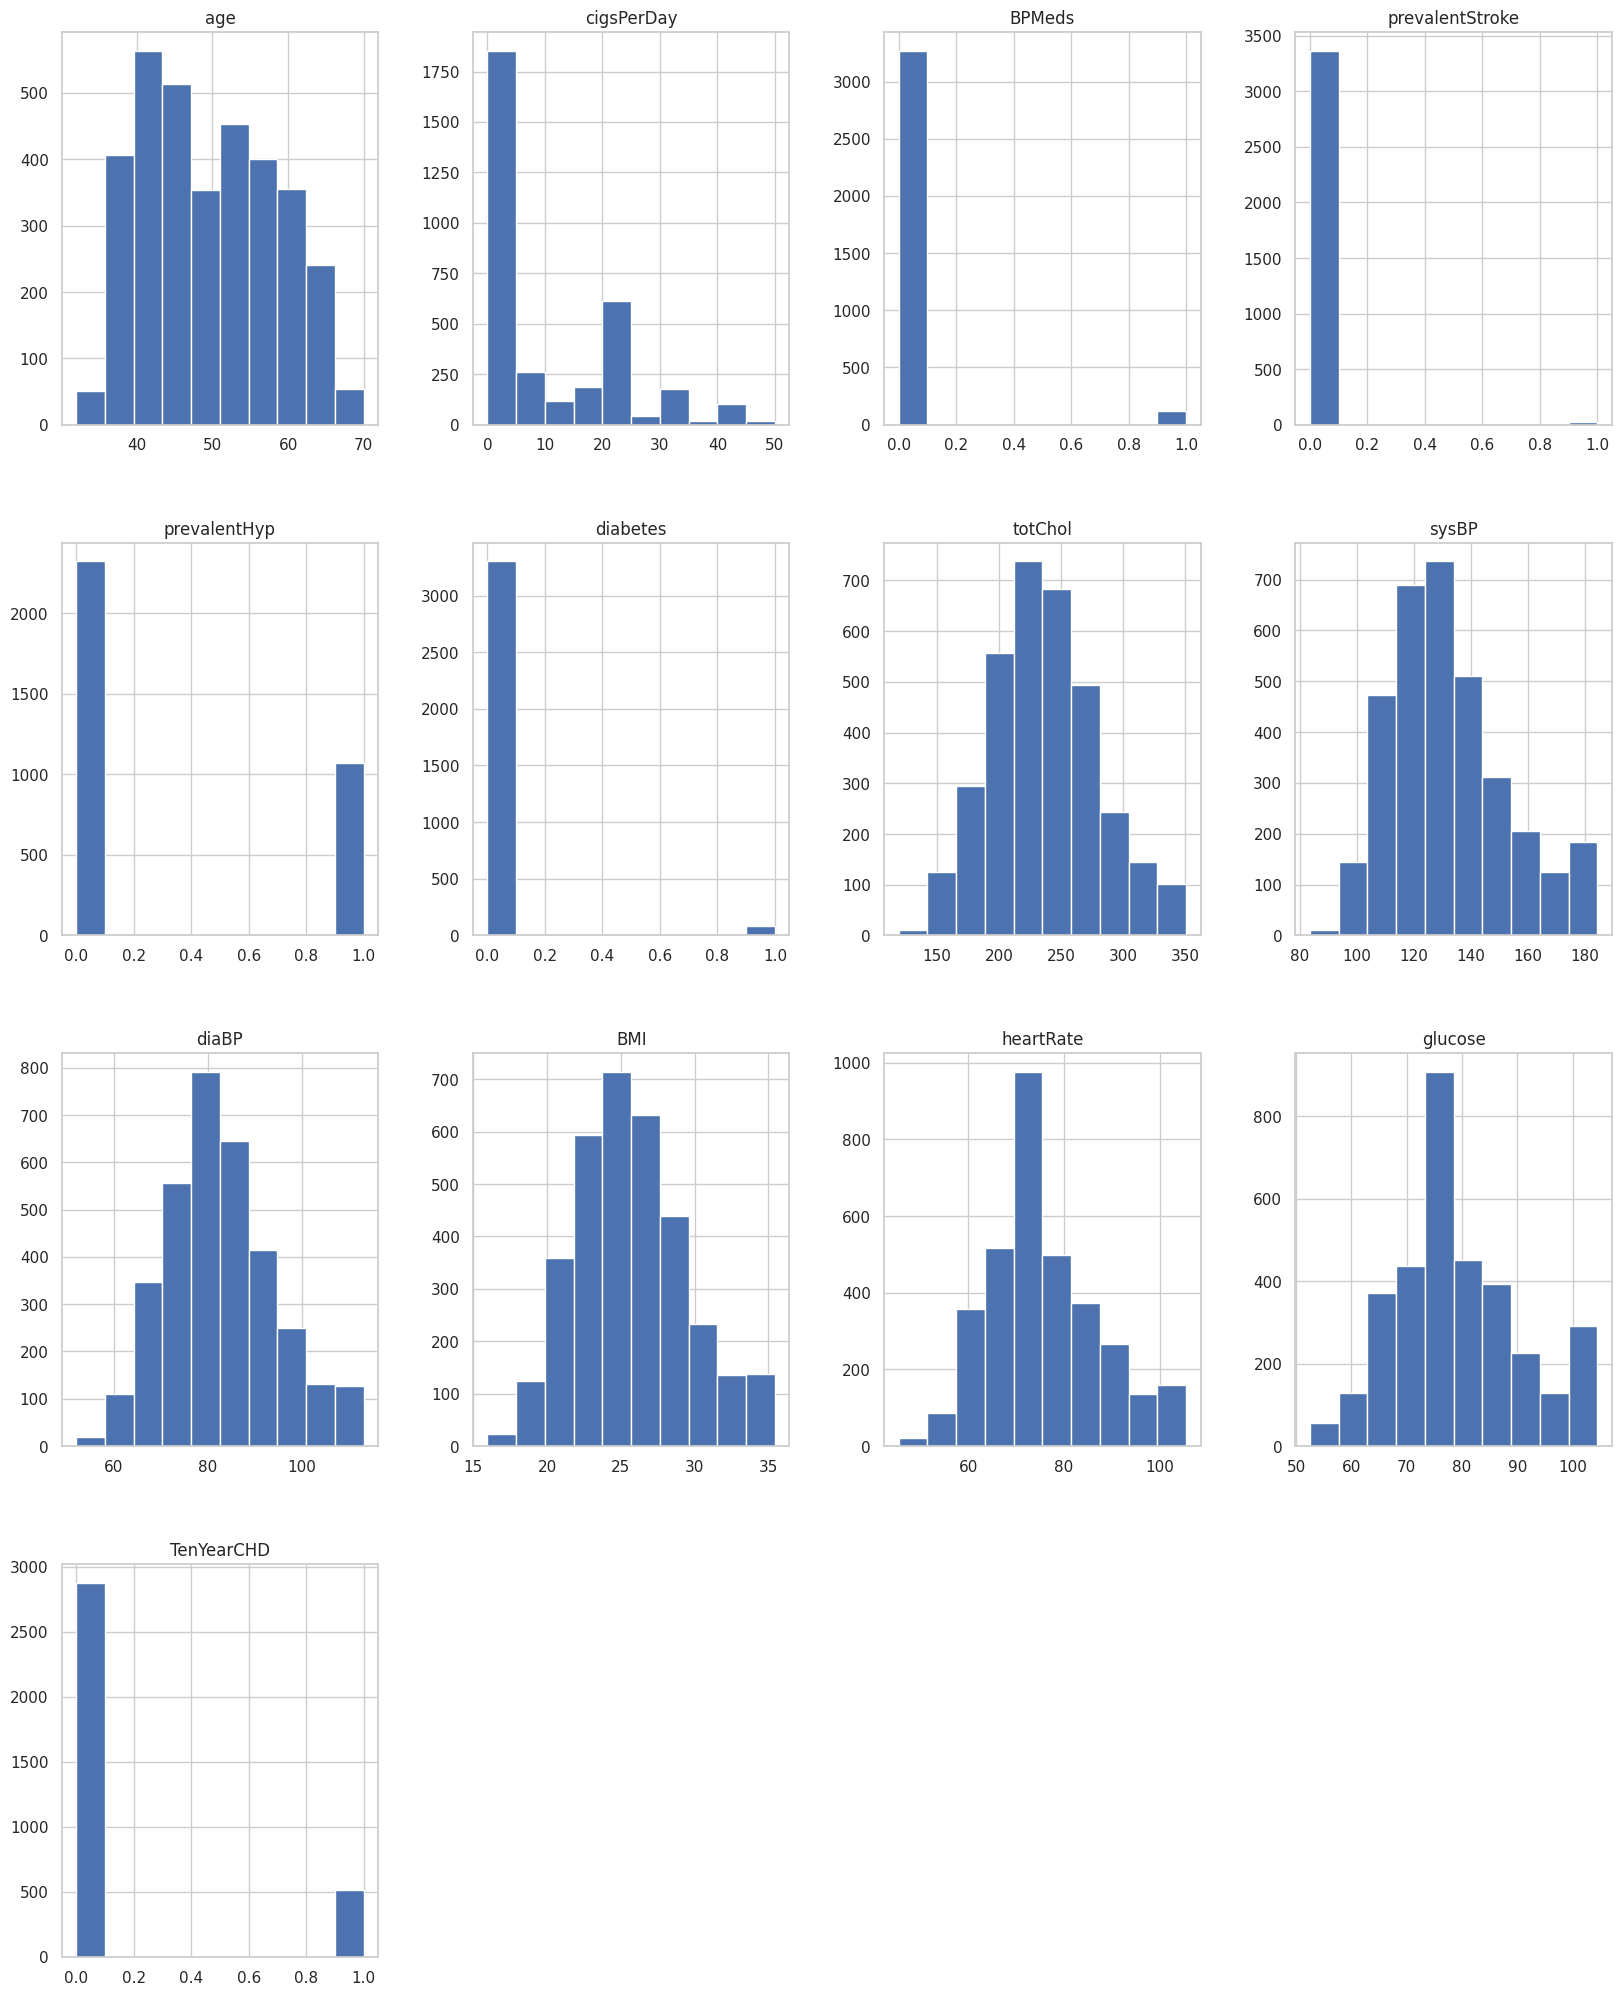

In [69]:
# plot histogram to see the distribution of the data
fig = plt.figure(figsize = (20,25))
ax = fig.gca()
dataset.hist(ax = ax) #color='light blue')
plt.show()

**Bi-Variate Analysis**

Bivariate analysis is a statistical method used in data analysis and research to explore and understand the relationships between two different variables. It primarily focuses on examining how changes in one variable are associated with changes in another variable.

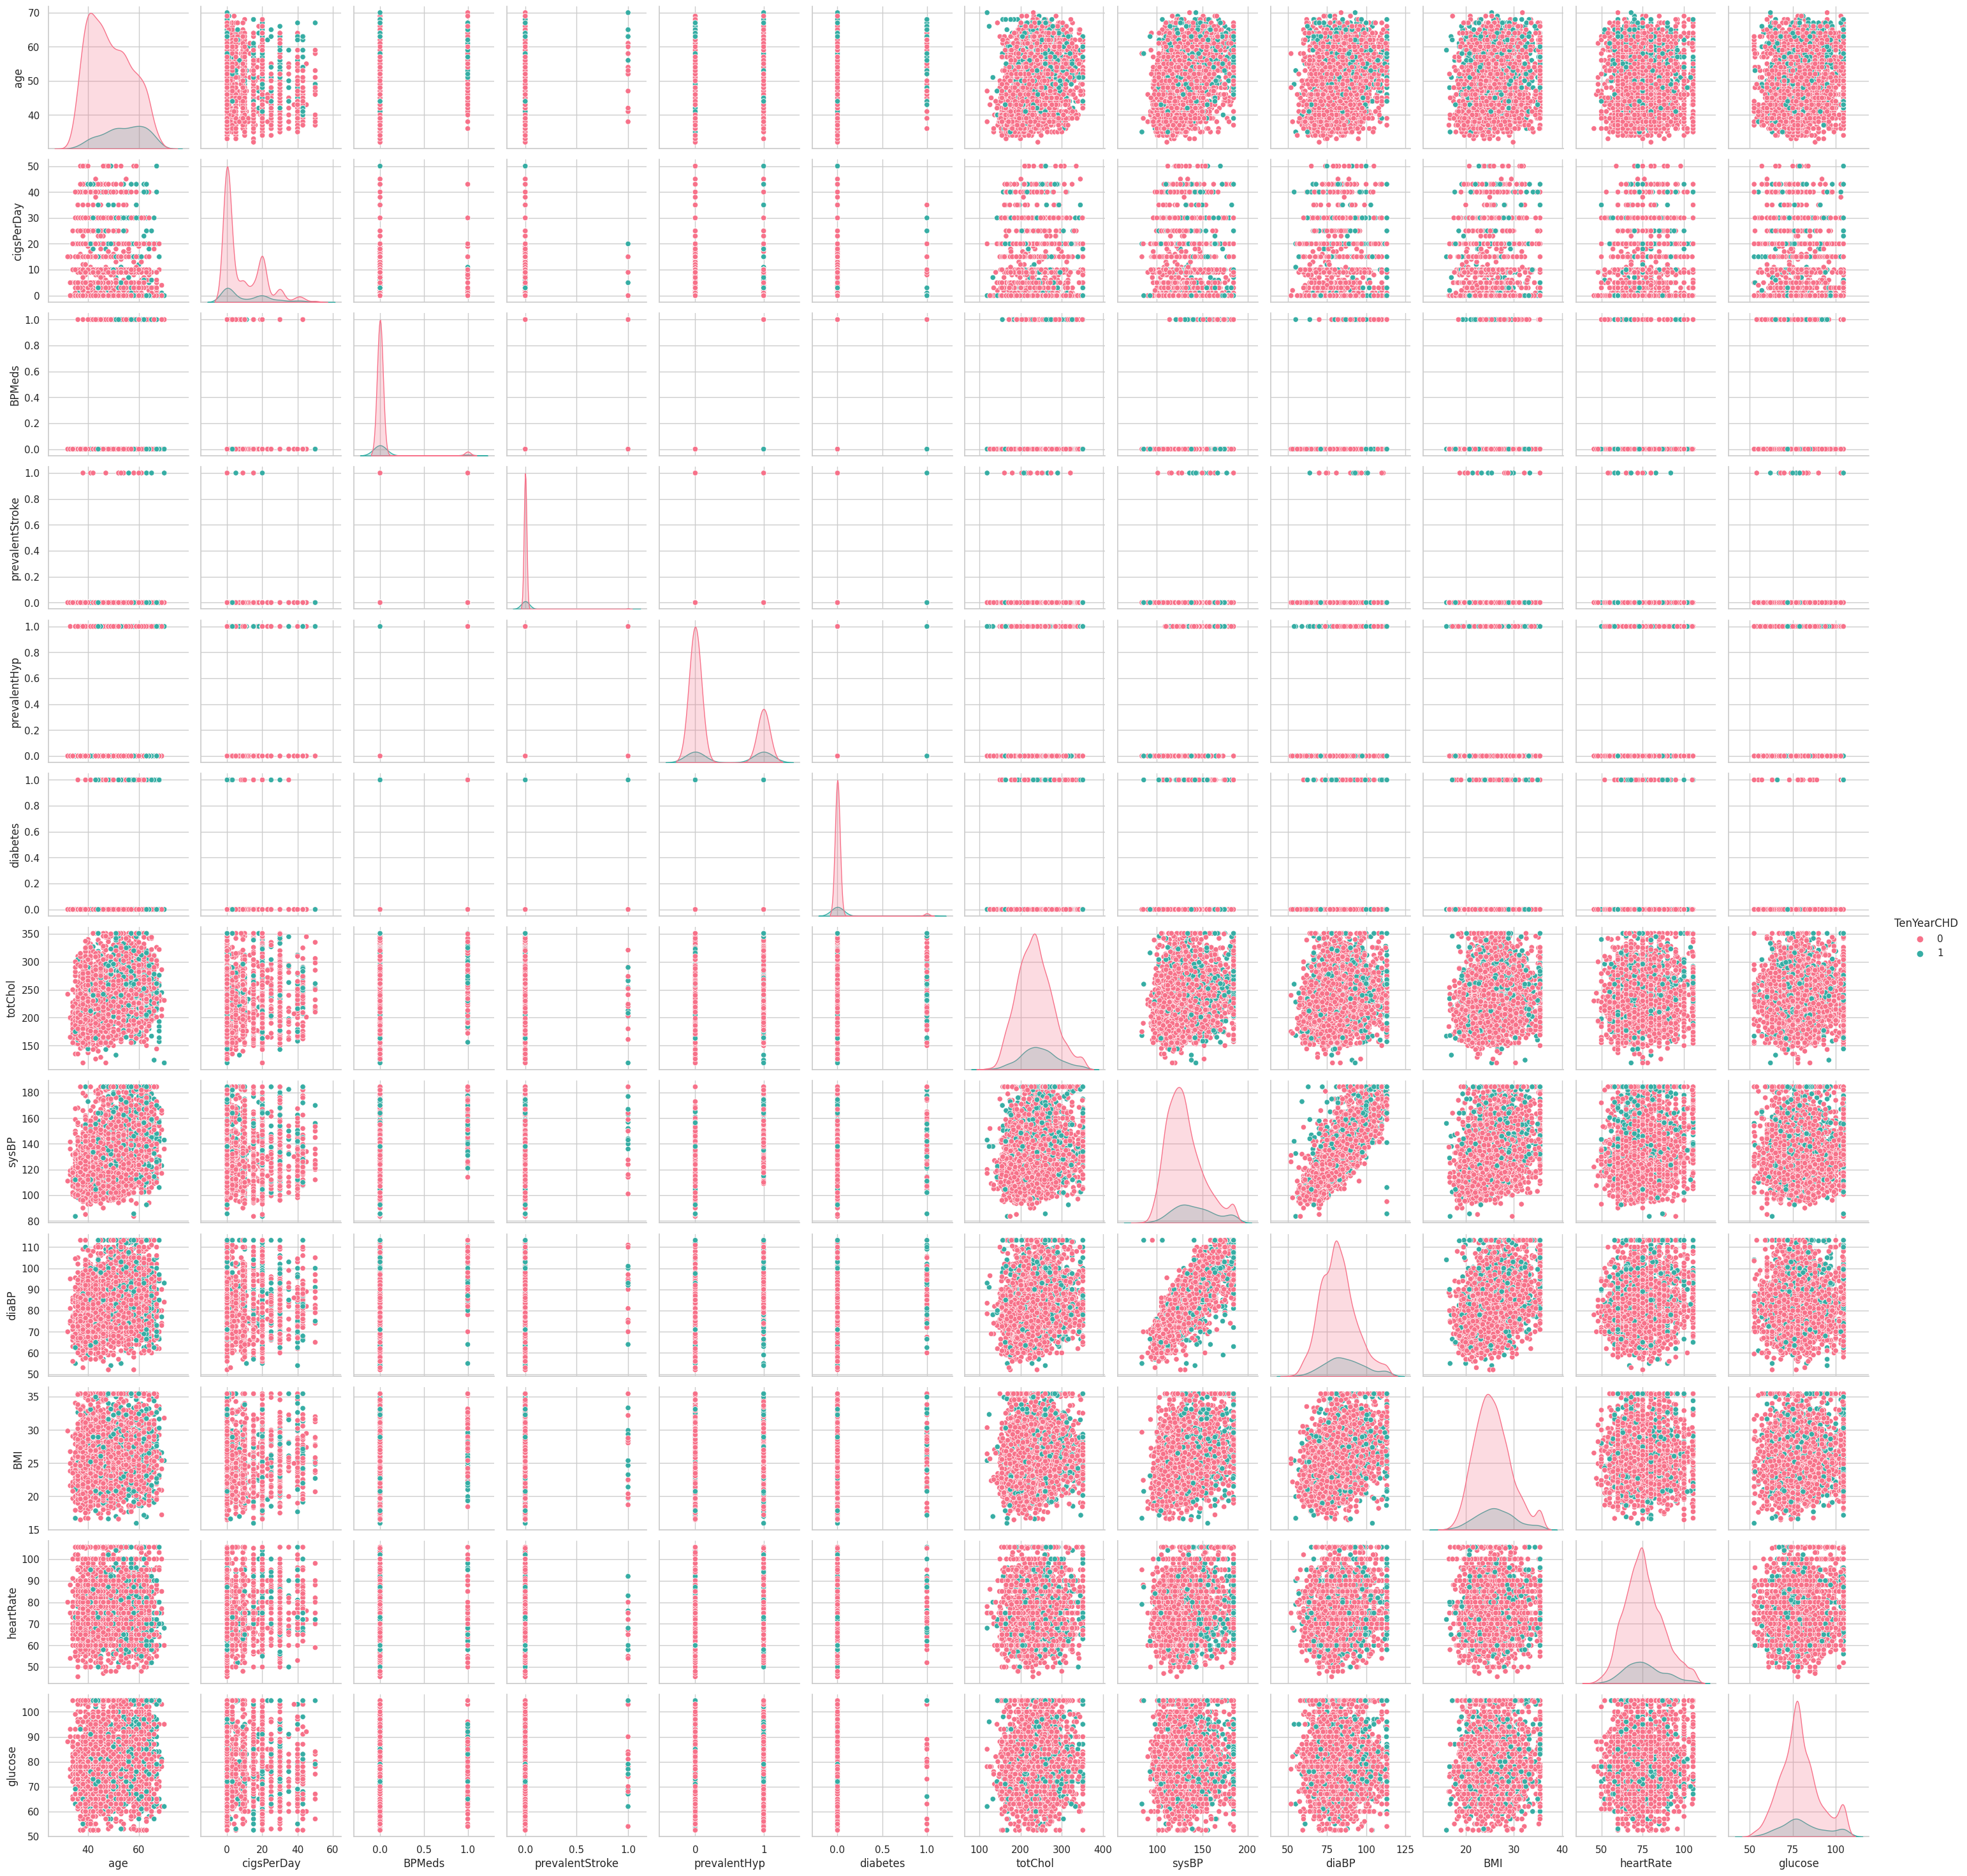

In [70]:
sns.pairplot(dataset, hue ='TenYearCHD', palette='husl')
plt.show()

In [71]:
#From the above, we can segredate continuous and categorical variable
continuous_features = ['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']
categorical_features = ['BPMeds','prevalentStroke','prevalentHyp','diabetes']

**Multivariate Analysis**

Multivariate analysis is a statistical technique used to analyze and understand the relationships between three or more variables simultaneously. While univariate analysis deals with a single variable and bivariate analysis focuses on the relationship between two variables, multivariate analysis extends the scope to involve multiple variables.

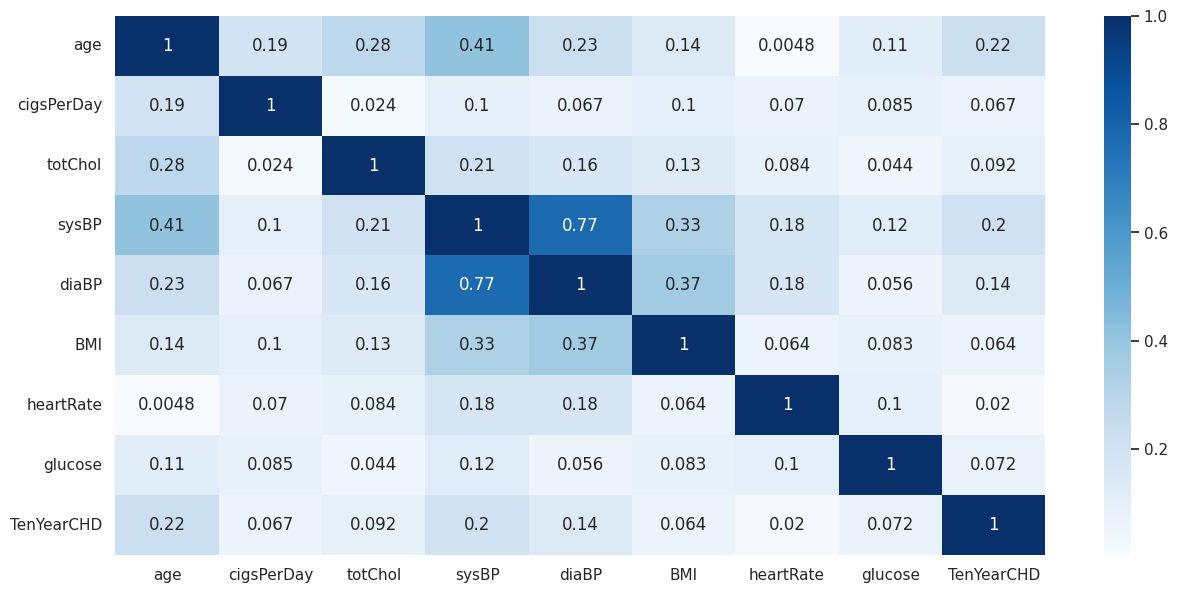

In [72]:
# Plotting heatmap for numerical variables
plt.figure(figsize=(15,7))
sns.heatmap (abs(dataset.drop(categorical_features, axis=1).corr()),annot = True, cmap='Blues')
plt.show()

In [73]:
# Getting the variance inflaction factor dataframe
vif_df = calc_vif(dataset[[i for i in dataset.describe().columns if i not in ['TenYearCHD','prevalentHyp','diabetes','prevalentStroke',
                                                                             'diaBP','BMI','heartRate','totChol','BPMeds' ]]])
vif_df

variables        VIF
0         age  37.383371
1  cigsPerDay   1.562149
2       sysBP  41.953779
3     glucose  30.221297

In [74]:
numerical_features=list(vif_df['variables'])
numerical_features

['age', 'cigsPerDay', 'sysBP', 'glucose']

Changing the datatype of categorical features

In [75]:
categorical_features.extend(['sex','is_smoking'])
categorical_features

['BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'sex', 'is_smoking']

In [76]:
#Changing datatype
#Change the int64 column into category column
for col in categorical_features:
  dataset[col]=dataset[col].astype('category')

Visualizing categorical features

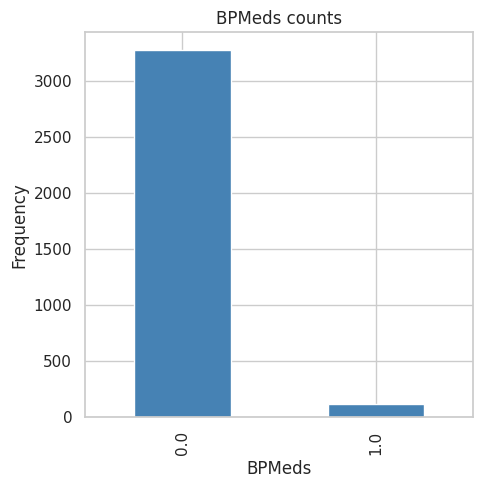

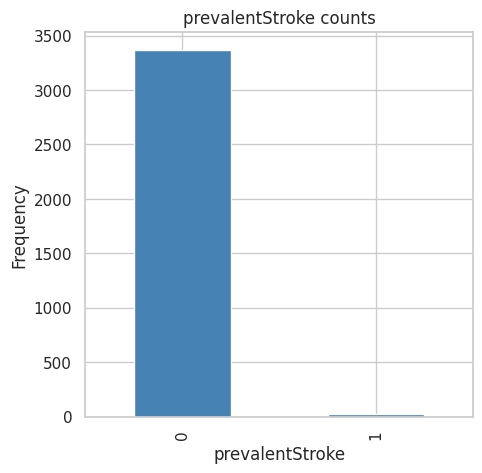

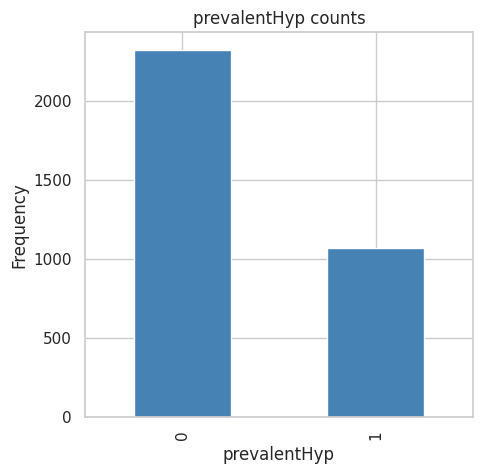

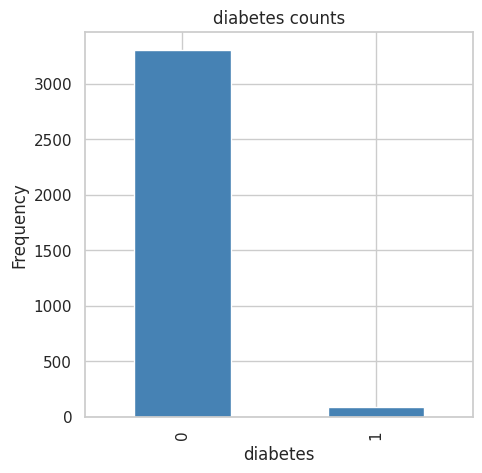

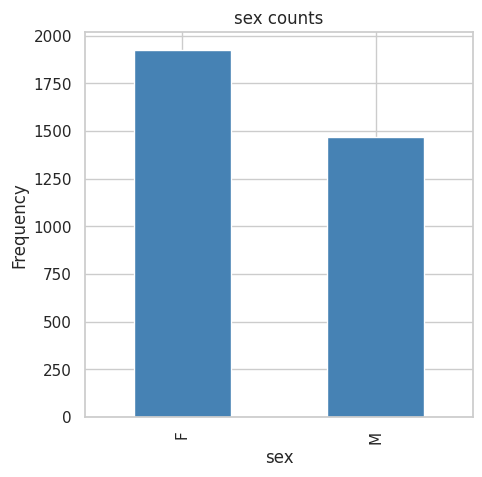

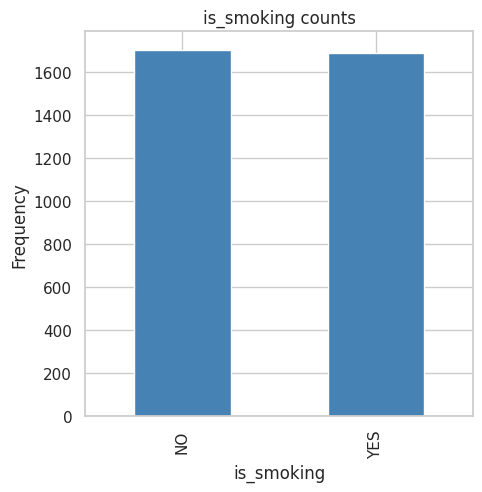

In [77]:
for col in categorical_features:
    counts = dataset[col].value_counts().sort_index()
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
plt.show()

One hot encoding

A one hot encoding allows the representation of categorical data to be more expressive. Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers. This is required for both input and output variables that are categorical.

In [78]:
#Encoding the binary categorical columns
encoders_nums = {"sex":{"M":1,"F":0},"is_smoking":{"YES":1,"NO":0}}

In [79]:
#As we are taking continuous column cigsPerDay, we are dropping is_smoking column
dataset.drop('is_smoking',axis=1,inplace=True)
categorical_features.remove('is_smoking')

In [80]:
dataset = dataset.replace(encoders_nums)
dataset.head()

age sex  cigsPerDay BPMeds prevalentStroke prevalentHyp diabetes  totChol  \
0   64   0         3.0    0.0               0            0        0    221.0   
1   36   1         0.0    0.0               0            1        0    212.0   
2   46   0        10.0    0.0               0            0        0    250.0   
3   50   1        20.0    0.0               0            1        0    233.0   
4   64   0        30.0    0.0               0            0        0    241.0   

   sysBP  diaBP    BMI  heartRate  glucose  TenYearCHD  
0  148.0   85.0  25.38       90.0     80.0           1  
1  168.0   98.0  29.77       72.0     75.0           0  
2  116.0   71.0  20.35       88.0     94.0           0  
3  158.0   88.0  28.26       68.0     94.0           1  
4  136.5   85.0  26.42       70.0     77.0           0

**Feature Selection**

We are including the 'sysBP' column, which is associated with a person's blood pressure, in our feature set. Consequently, we have decided to remove the 'prevalentHyp' column, as it provides redundant information related to hypertension.

Considering the low occurrence of 'prevalentStroke' ones in the column, its inclusion would have minimal impact on our model building. Therefore, we have opted to exclude the 'prevalentStroke' column from our analysis.

Given that we are already considering the 'glucose' column, which serves as an indicator of diabetes, we find it appropriate to drop the 'diabetes' column.

Additionally, we have chosen to remove the 'BPMeds' column due to a significant class imbalance. Notably, we already have another column related to blood pressure, making 'BPMeds' redundant for our analysis.

In [81]:
features = numerical_features + categorical_features
features.remove('prevalentHyp')
features.remove('prevalentStroke')
features.remove('diabetes')
features.remove('BPMeds')

In [82]:
#These are the features that we are using to train our model
features

['age', 'cigsPerDay', 'sysBP', 'glucose', 'sex']

In [83]:
dataset[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age         3390 non-null   int64   
 1   cigsPerDay  3390 non-null   float64 
 2   sysBP       3390 non-null   float64 
 3   glucose     3390 non-null   float64 
 4   sex         3390 non-null   category
dtypes: category(1), float64(3), int64(1)
memory usage: 109.5 KB


**Model Prerequisites**

In [84]:
from scipy.stats import zscore

In [85]:
dataset[features] = dataset[features].astype(float)

In [86]:
#Scaling the input columns
X = dataset[features].apply(zscore)


In [87]:
Y = dataset['TenYearCHD']

In [88]:
#Scoring is used to define the parameter we are concentrating on to maximize
scoring = make_scorer(f1_score , pos_label = 1)

**Smote Tomek**

We have observed a significant imbalance in the dependent variable, prompting us to apply the Synthetic Minority Over-sampling Technique (SMOTE) to address this issue.

SMOTE, which stands for Synthetic Minority Oversampling Technique, is a method that focuses on generating synthetic data points for the minority class to rebalance the dataset.

However, to further enhance the effectiveness of the model and optimize classifier performance, we have implemented an improved hybridization technique known as SMOTE-TOMEK. This technique combines both oversampling and undersampling approaches.

In SMOTE, oversampling is performed to create synthetic data points for the minority class. While this helps balance the class distribution, it can lead to clusters of class observations overlapping, potentially causing overfitting issues for classifier models.

To mitigate this, we introduce TOMEK links. TOMEK links are pairs of data points from different classes that are the closest neighbors to each other. By removing the majority class observations from these links, we enhance class separation near the decision boundaries. In the context of SMOTE, TOMEK links are applied to the oversampled minority class samples generated by SMOTE. This process ultimately results in improved class clusters and aids in preventing overfitting, thus contributing to more robust model performance.







In [89]:
# from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.20, random_state=0, stratify= Y)

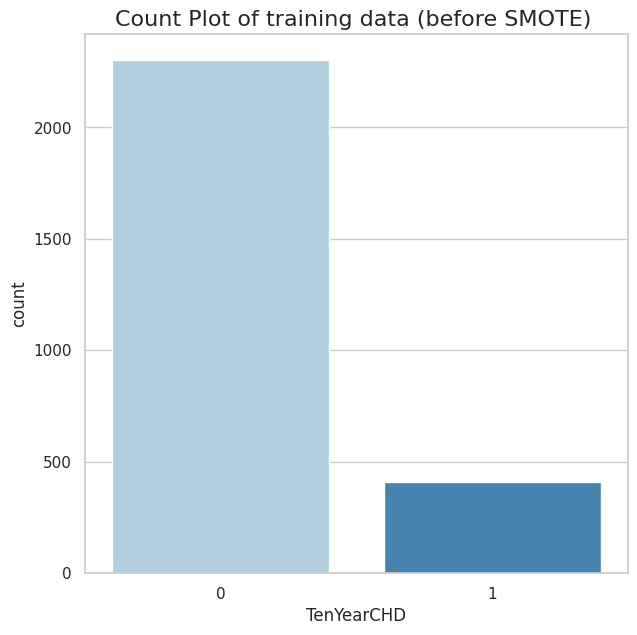

In [90]:
plt.figure(figsize=(7,7))
sns.countplot(x=Y_train,palette='Blues')
plt.title("Count Plot of training data (before SMOTE) ",fontsize=16)
plt.show()

In [91]:
#Applying smote for train data
X_smotetomek, y_smotetomek = SMOTETomek(random_state=0, sampling_strategy='minority').fit_resample(X_train, Y_train)

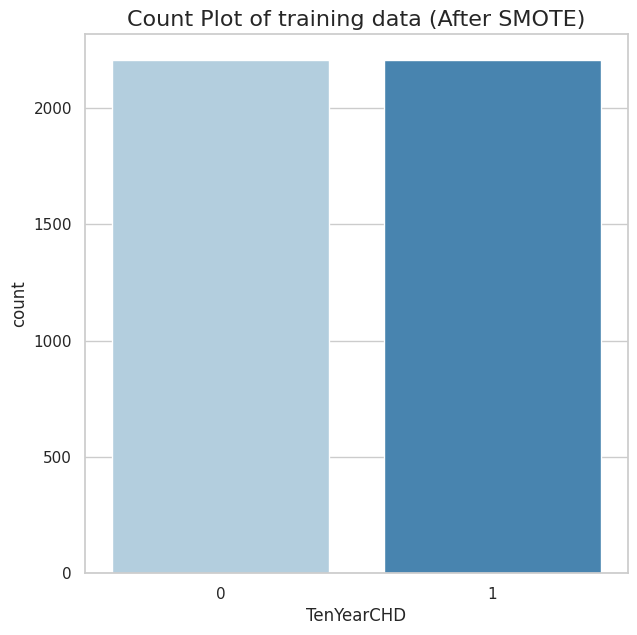

In [92]:
plt.figure(figsize=(7,7))
sns.countplot(x=y_smotetomek,palette='Blues')
plt.title("Count Plot of training data (After SMOTE)",fontsize=16)
plt.show()

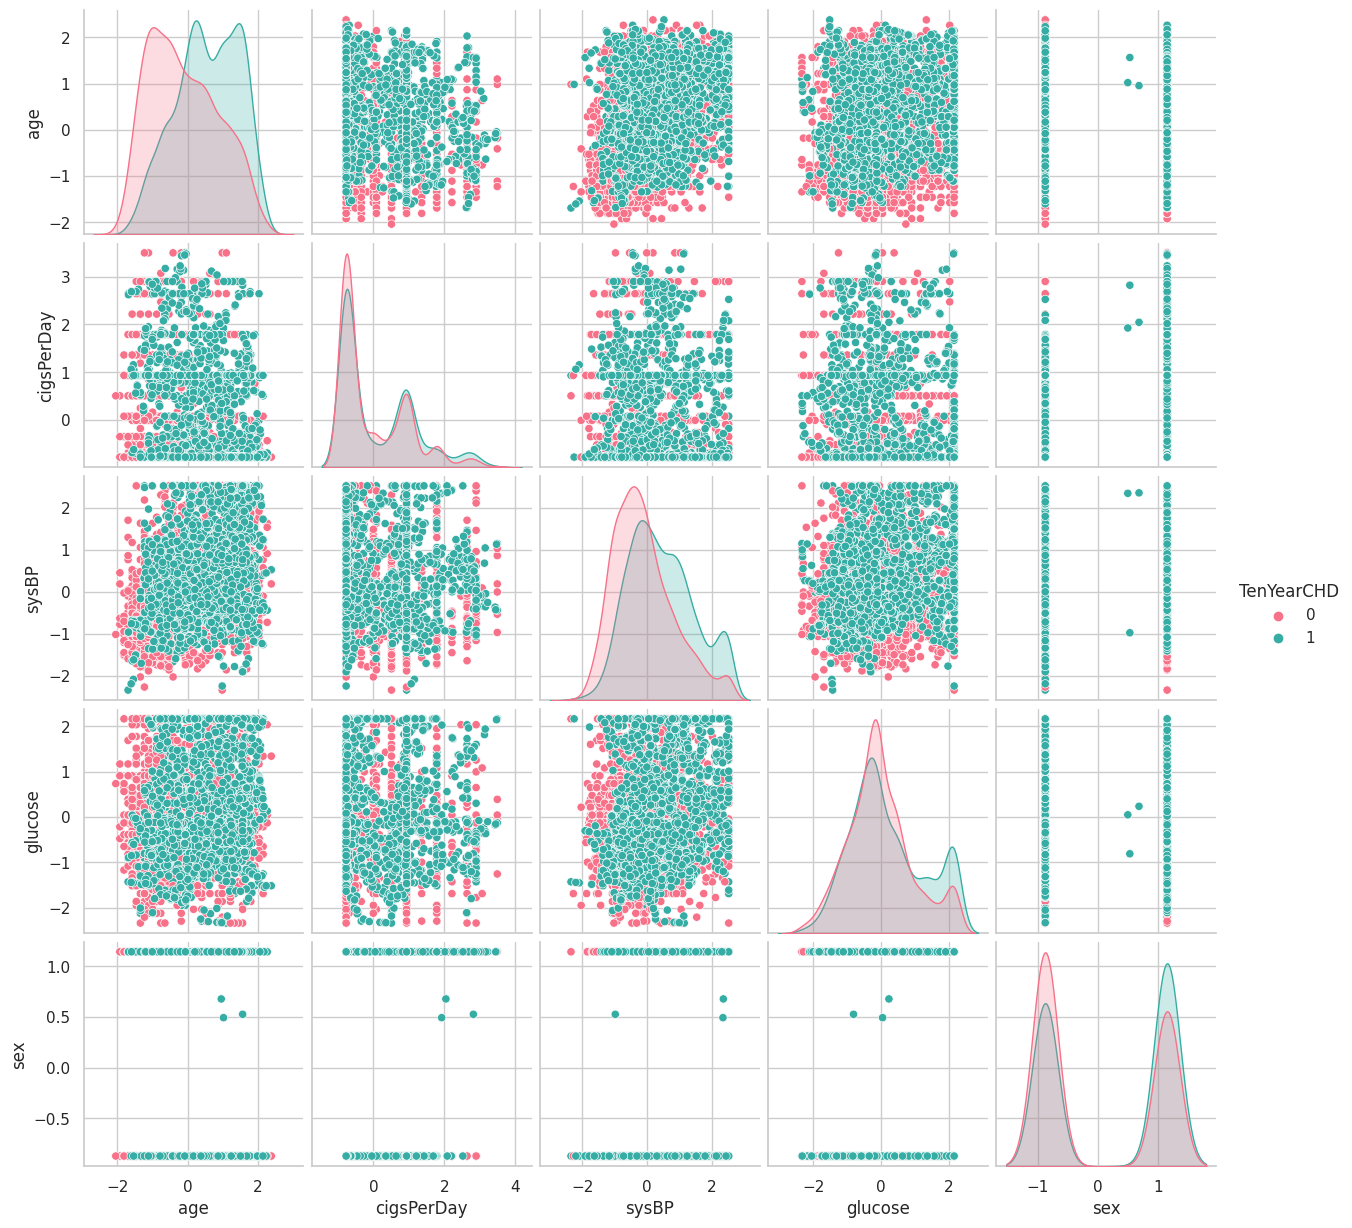

In [93]:
#Printing pairplot for the features after smote
smotetoemk_df = pd.concat([X_smotetomek,y_smotetomek], axis = 1)
sns.pairplot(smotetoemk_df, hue='TenYearCHD',palette='husl')
plt.show()

**Models**

**Evaluation Metrics**

**True Positive(TP):** A positive sample was retrieved, which is actually a positive sample (correctly identified)


**False Positive(FP):** A positive sample was retrieved, but it was actually a negative sample (a type of misidentification)


**False Negative(FN):** No positive sample has been retrieved, but it is actually a positive sample. (Another type of misidentification)


**True Negative(TN):** No positive sample has been retrieved, but it is actually a negative sample. (Correct identification)





**Precision:** The precision is the ratio of tp/(tp + fp), where tp is the correct number of positive samples and fp is the number of false positives.

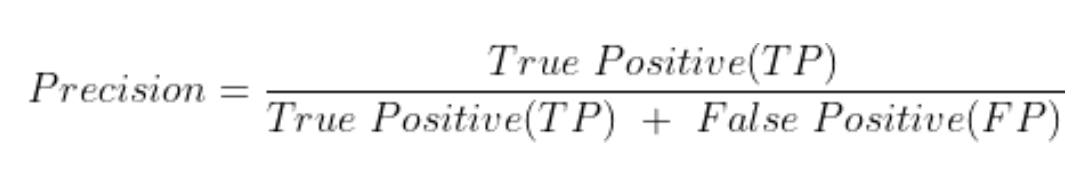

**Recall:**  Recall tell us how sensitive our model is to the positive class, and we see it is also referred to as Sensitivity. Recall measures the proportion of actual positive labels correctly identified by the model.

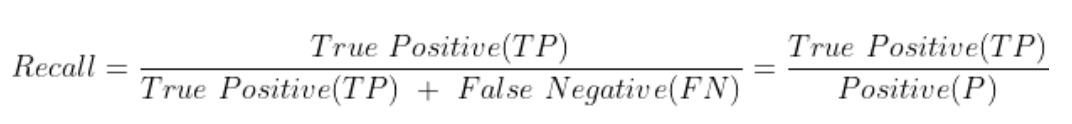

**Accuracy:** In machine learning, accuracy is defined as the proportion of correct predictions in all predictions made.

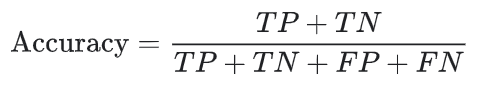



**F1 Score:** F1 score is a metric that combines both Precision and Recall. Also f1-score lies between 0 to 1 and the higher, the better.

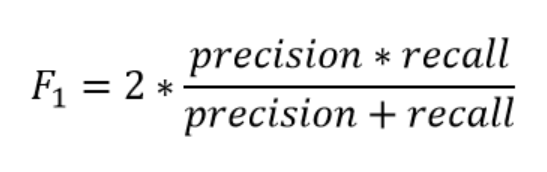

**ROC-AUC:** ROC stands for Receiver Operating Characteristic. The ROC curve is a graphical plot. Its purpose is to illustrate our classification model’s ability to distinguish between classes at various thresholds.

AUC is the acronym for the Area Under Curve. It is the summary of the ROC curve that tells about how good a model is when we talk about its ability to generalize.

Greater the area under this curve (AUC), the greater the model’s ability to separate the responses.



**Logistic Regression**

Logistic Regression is a widely used statistical and machine learning technique for binary classification problems, where the target variable has two possible classes (e.g., 0 or 1, yes or no).

In [94]:
from sklearn.impute import SimpleImputer

In [95]:
imputer = SimpleImputer(strategy='mean')
X =imputer.fit_transform(X)
X_test = imputer.transform(X_test)
X_smotetomek = imputer.transform(X_smotetomek)

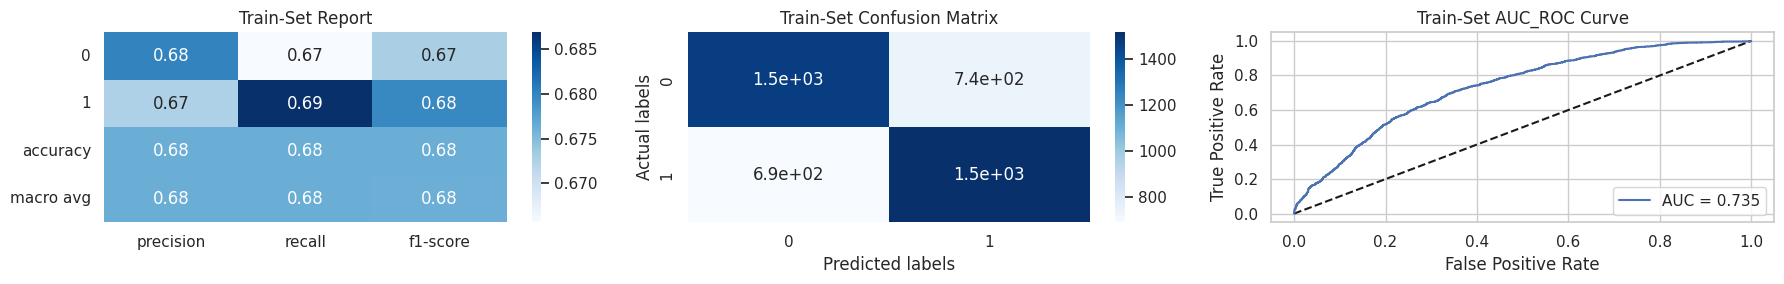

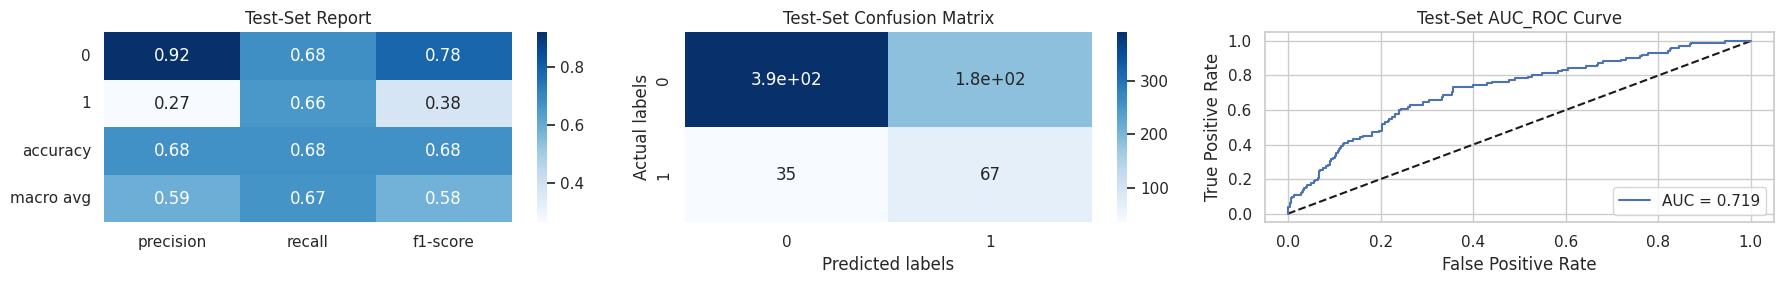

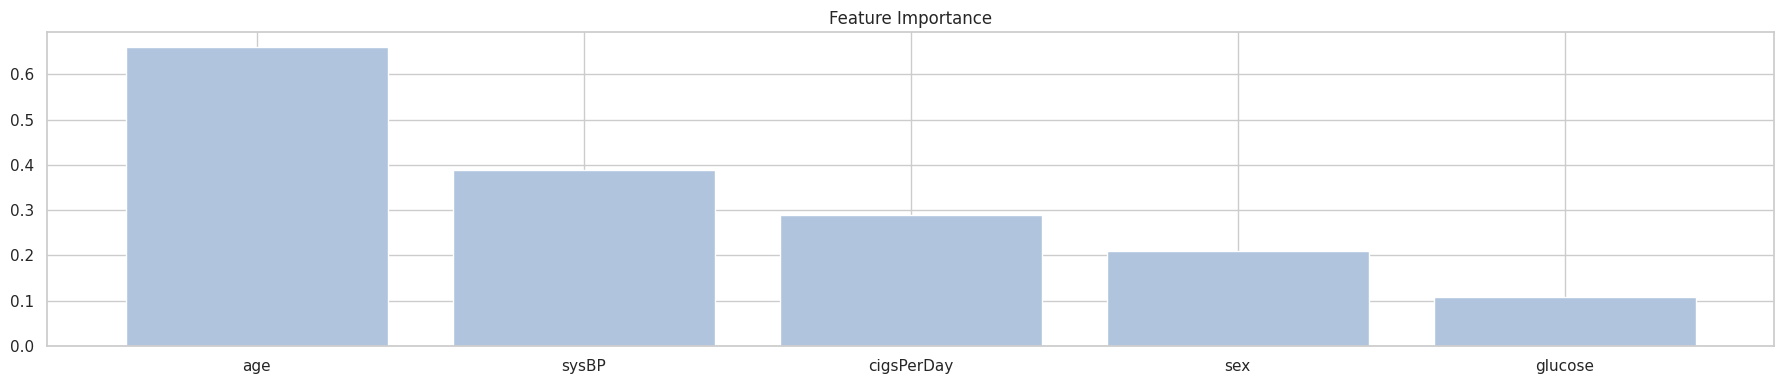

LogisticRegression(max_iter=1000)

In [96]:
reg = LogisticRegression(max_iter=1000)
analyse_model(reg,X_smotetomek,X_test,y_smotetomek,Y_test)

**Random Forest Classifier**

A Random Forest Classifier is a machine learning model used for classification tasks. It's an ensemble learning method that combines multiple decision trees to make predictions. Random Forests are known for their robustness, accuracy, and ability to handle high-dimensional dataset

In [97]:
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [98]:
# Create an instance of the RandomForestClassifier
rf_model = RandomForestClassifier()

# Grid search to fit the model for 5 fold cross validation
rf_grid = GridSearchCV(estimator=rf_model,
                       param_grid = param_dict,
                       scoring = scoring,
                       cv = 5, #verbose=2,
                       )

print("Fitting the model for 5 fold Cross Validations...")
rf_grid.fit(X_smotetomek,y_smotetomek)



Fitting the model for 5 fold Cross Validations...


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 100, 150],
                         'n_estimators': [50, 80, 100]},
             scoring=make_scorer(f1_score, pos_label=1))

In [99]:
print(f'The best estimator model is {rf_grid.best_estimator_}')
print(f'The best fit parameters are {rf_grid.best_params_}')

The best estimator model is RandomForestClassifier(max_depth=8, min_samples_leaf=40, min_samples_split=100)
The best fit parameters are {'max_depth': 8, 'min_samples_leaf': 40, 'min_samples_split': 100, 'n_estimators': 100}


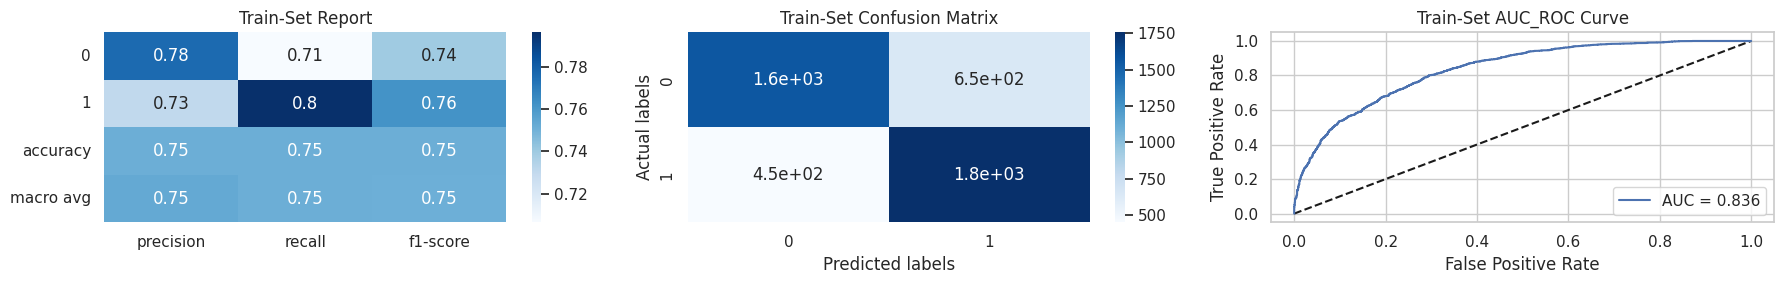

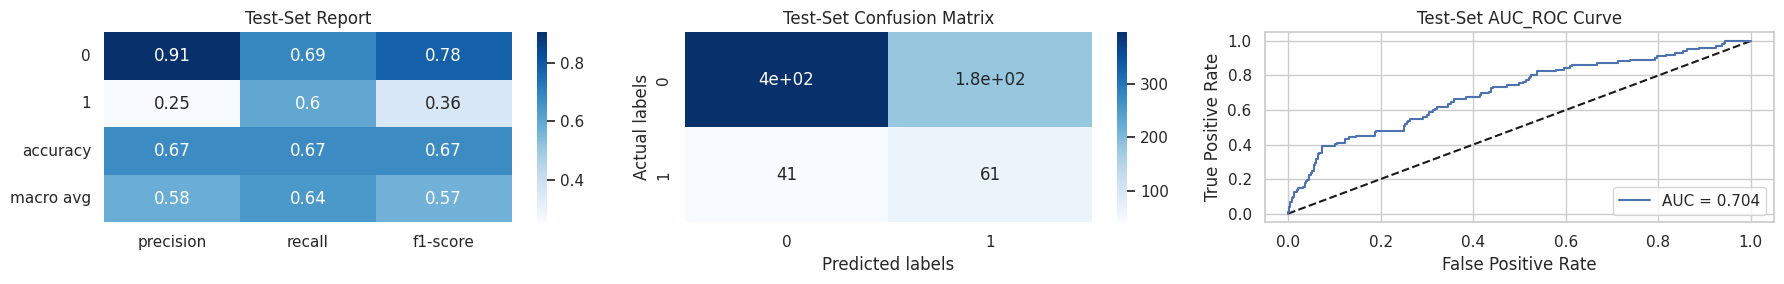

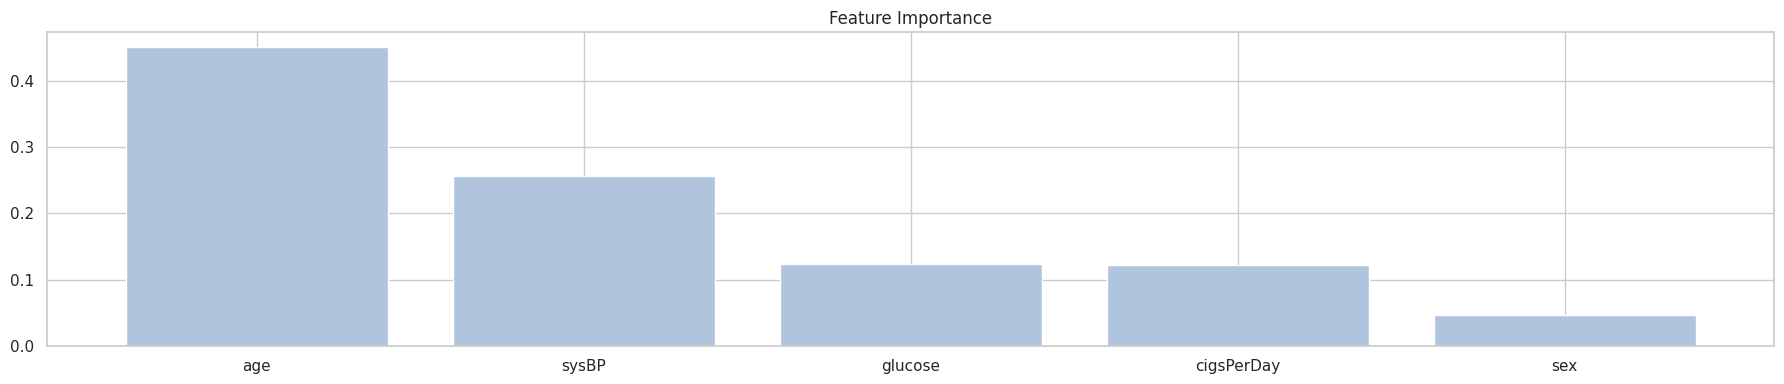

RandomForestClassifier(max_depth=8, min_samples_leaf=40, min_samples_split=100)

In [100]:
analyse_model(rf_grid.best_estimator_, X_smotetomek, X_test, y_smotetomek, Y_test)

**Extreme Gradient Boost Classifier(XGB)**

The Extreme Gradient Boosting Classifier, commonly known as XGBoost, is a powerful and widely used machine learning algorithm for both classification and regression tasks. It is known for its exceptional predictive accuracy, speed, and efficiency. XGBoost is an extension of the Gradient Boosting method and is popular in various machine learning competitions and real-world applications

In [101]:
# Number of trees
n_estimators = [140,160]

# # # Maximum depth of trees
# max_depth = [4,6]

# learning rate for the model
learning_rate=[0.1,0.01,0.001]

# # Minimum number of sub samples required
# subsample=[0.6,0.7,0.8]

#minimum sample split
min_sample_split = [20,30,40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [30,50,70]


# Hyperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              # 'max_depth' : max_depth,
              'learning_rate' : learning_rate,
              # 'subsample' : subsample
              'min_sample_split':min_sample_split,
              'min_samples_leaf':min_samples_leaf}

# Create an instance of the RandomForestClassifier
xgb_model = xgb.XGBClassifier()

# Grid search
xgb_grid = GridSearchCV(estimator=xgb_model,
                       param_grid = param_dict,
                        scoring = scoring,
                       cv = 5, #verbose=2,
                        )

print("Fitting the model for 5 fold Cross Validations...")
xgb_grid.fit(X_smotetomek,y_smotetomek)


Fitting the model for 5 fold Cross Validations...


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'min_sample_split': [20, 30, 40],
                         'min_samples_leaf': [30, 50, 70],
                         'n_estimators': [140, 160]},
             scoring=make_scorer(f1_score, pos_label=1))

In [102]:
print(f'The best estimator model is {xgb_grid.best_estimator_}')
print(f'The best fit parameters are {xgb_grid.best_params_}')

The best estimator model is XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_sample_split=20, min_samples_leaf=30,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=160, n_jobs=None, ...)
The best fit parameters are {'learning_rate': 0.1, 'min_sample_split': 20, 'min_samples_leaf': 30, 'n_estimators': 160}


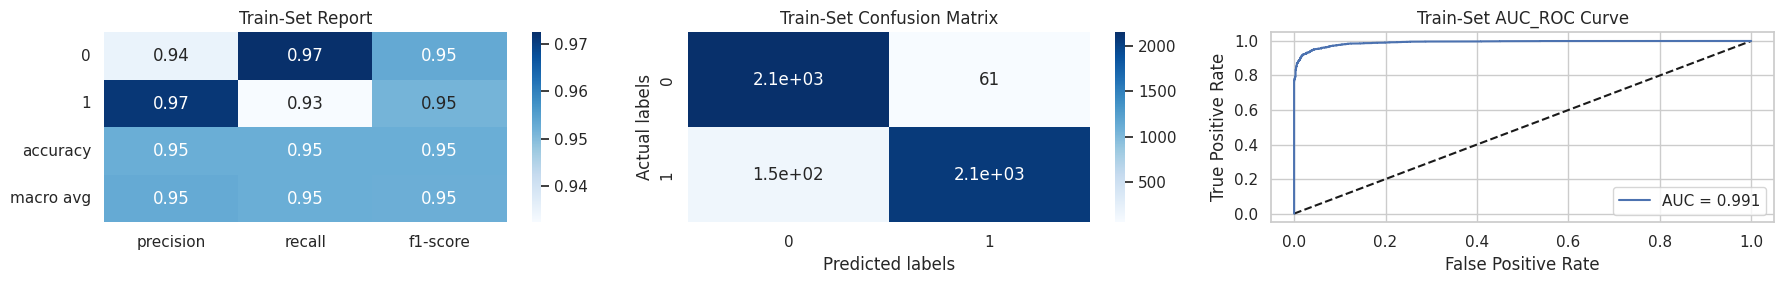

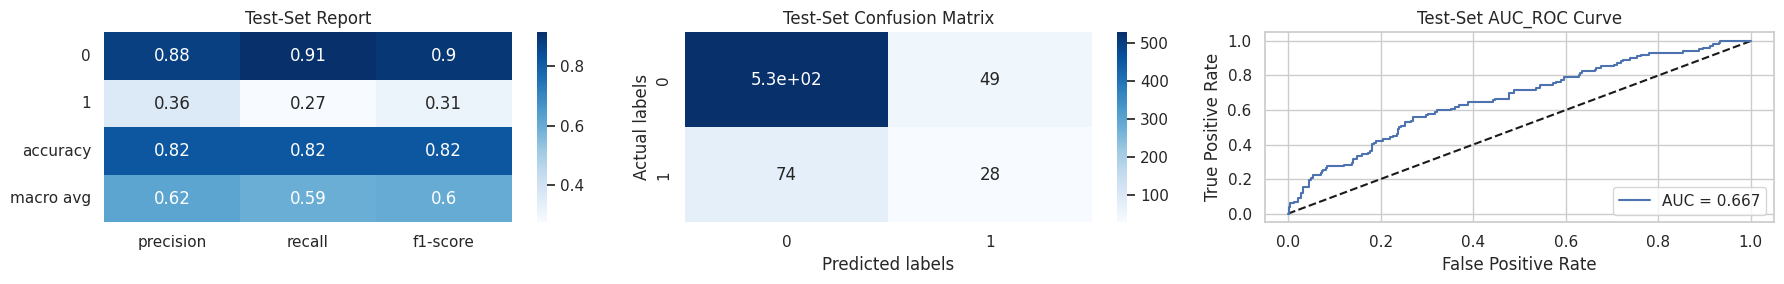

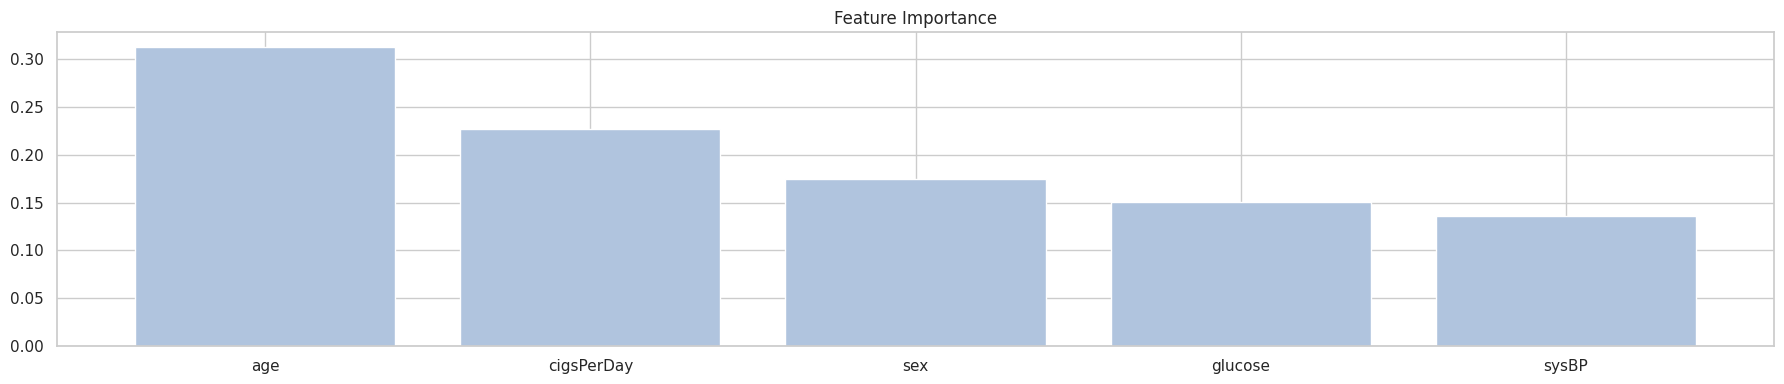

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_sample_split=20, min_samples_leaf=30,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=160, n_jobs=None, ...)

In [103]:
analyse_model(xgb_grid.best_estimator_, X_smotetomek, X_test, y_smotetomek, Y_test)

**Suppot Vector Classifier(SVM)**


A Support Vector Classifier (SVC), often referred to as a Support Vector Machine (SVM), is a supervised machine learning algorithm used for both classification and regression tasks. SVM is especially popular for classification problems and is known for its ability to find the optimal hyperplane that best separates data into distinct classes.

In [104]:
# SVM algorithm
clf = SVC(random_state= 0,probability=True)
# scoring_1 = make_scorer(f1_score, pos_label = 1)
# HYperparameter Grid
grid = {'kernel': ["linear","rbf","poly","sigmoid"],
        'C': [0.01,0.1, 1, 10, 100],
        'max_iter' : [1000]}

# GridSearch to find the best parameters
svc = GridSearchCV(clf, param_grid = grid, scoring = scoring, cv=5)
print('Fitting the model for 5 fold Cross Validation')
svc.fit(X_smotetomek, y_smotetomek)



Fitting the model for 5 fold Cross Validation


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=0),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                         'max_iter': [1000]},
             scoring=make_scorer(f1_score, pos_label=1))

In [105]:
print(f'The best estimator model is {svc.best_estimator_}')
print(f'The best fit parameters are {svc.best_params_}')

The best estimator model is SVC(C=0.01, max_iter=1000, probability=True, random_state=0)
The best fit parameters are {'C': 0.01, 'kernel': 'rbf', 'max_iter': 1000}


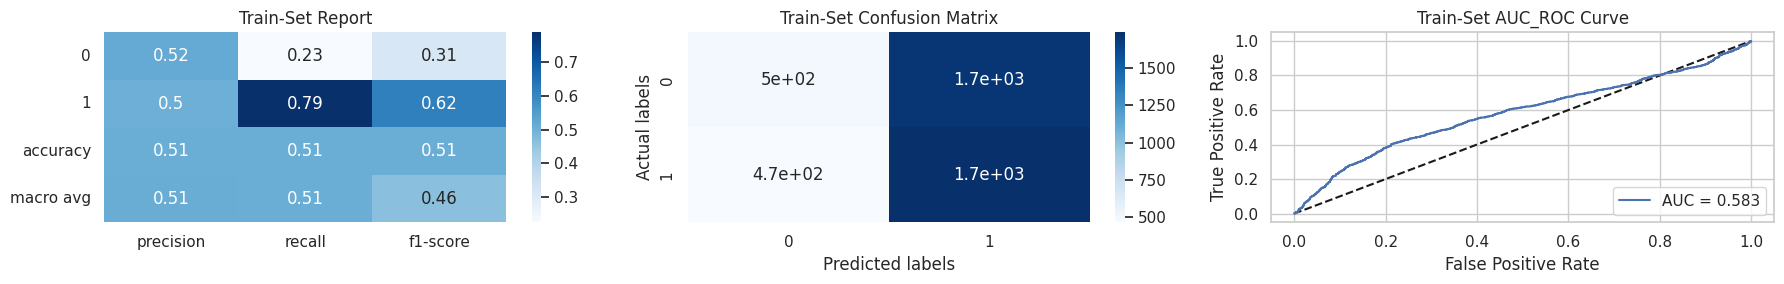

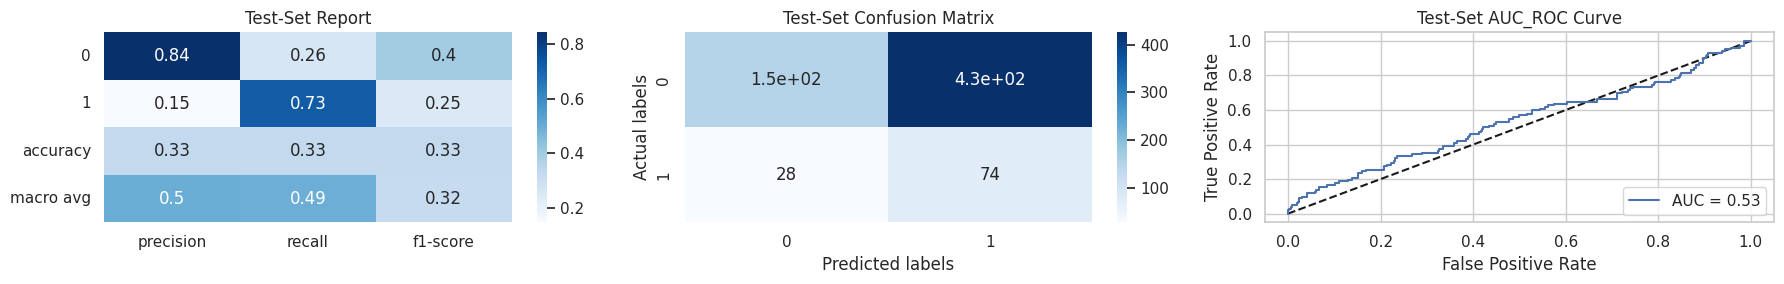

<Figure size 1800x400 with 0 Axes>

SVC(C=0.01, max_iter=1000, probability=True, random_state=0)

In [106]:
# Analysing the model with best set of parametes
analyse_model(svc.best_estimator_, X_smotetomek, X_test, y_smotetomek , Y_test)

**Conclusion**

Upon our initial exploration of the dataset, we conducted a comprehensive Exploratory Data Analysis (EDA) to acquaint ourselves with the dataset's features. Our findings lead us to the following conclusions:

1.Imbalanced Data: Out of a total of 3,390 records, only 500 individuals are identified as at risk for coronary heart disease (CHD). This indicates a substantial class imbalance within the dataset.

2.Age Significance: Age emerged as the most influential factor in predicting the likelihood of CHD within the next ten years. It plays a pivotal role in determining CHD risk.

3.Blood Pressure Impact: Systolic Blood Pressure ranked as the second most crucial feature for predicting CHD risk. It exhibits a strong relationship with the likelihood of developing CHD.

4.Gender Differences: Our analysis revealed a slightly higher predisposition among the male population to develop CHD in comparison to females.

5.Smoking and Risk: When individuals consume fewer cigarettes per day, there is a relatively balanced likelihood of developing CHD among smokers and non-smokers. However, as the number of cigarettes smoked per day increases, the risk of CHD also escalates. This signifies the importance of monitoring smoking habits in assessing CHD risk."







"We initiated the data cleaning process, which involved addressing missing values and handling outliers by setting caps. Subsequently, feature selection was performed, guided by techniques such as Variance Inflation Factor (VIF) analysis and correlation mapping.

To ensure a robust training and evaluation process, we partitioned the dataset into two subsets: a training set containing 80% of the data and a test set comprising the remaining 20%.

Recognizing the significant class imbalance in the dataset, we leveraged SMOTE (Synthetic Minority Oversampling Technique) to introduce synthetic data points. This technique was exclusively applied to the training split to avoid potential overfitting concerns. Additionally, TOMEK link removal was conducted to enhance the model's classification efficiency and overall performance.

Given that this classification task pertains to predicting an individual's health, it's imperative that we exercise caution. Misclassifying a Ten-year CHD condition as 'NO' when the actual result is 'YES' could have significant consequences. Therefore, our primary objective is to maximize the recall score for class 1 in our model. In other words, we aim to minimize the risk of false negatives, ensuring that we identify cases of Ten-year CHD accurately, even if it means a slightly higher rate of false positives.

After applying SMOTE to address class imbalance, we initiated our classification efforts with Logistic Regression. However, it became apparent that Logistic Regression alone was unable to achieve the desired level of accuracy in classifying the data effectively.

Subsequently, we explored alternative classification models, including the Random Forest Classifier and Gradient Boost Classifier. However, our findings revealed that the Support Vector Machine (SVM) Classifier outperformed the other models. Specifically, SVM exhibited a remarkable recall score of 93% on the training data and 89% on the test data for class 1.

In light of these results, we can confidently conclude that the Support Vector Classifier is the optimal choice for our classification task, delivering an impressive 89% recall score for class 1, which aligns with our desired accuracy.